In [ ]:
#ReRunning the model predictions on TF_IDF Coded Vectors

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [9]:
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [10]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [11]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 152.22421 seconds


In [12]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [13]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [14]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [15]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [10]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [11]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [12]:
#Saving train, cv and test data as pickle file
train_df.to_pickle('train_data.pkl')
test_df.to_pickle('test_data.pkl')
cv_df.to_pickle('cv_data.pkl')
pd.DataFrame(y_train).to_pickle('train_y.pkl')
pd.DataFrame(y_test).to_pickle('test_y.pkl')
pd.DataFrame(y_cv).to_pickle('cv_y.pkl')

In [2]:
train_df = pd.read_pickle("./train_data.pkl")
test_df = pd.read_pickle("./test_data.pkl")
cv_df = pd.read_pickle("./cv_data.pkl")
train_y = pd.read_pickle("./train_y.pkl")
test_y = pd.read_pickle("./test_y.pkl")
cv_y = pd.read_pickle("./cv_y.pkl")

<h4>Stacking the three types of features</h4>

<h2 align="center"> TF-IDF Vectorization of Data </h2>

In [6]:
# TF-IDF Vectorization of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_tfidfvector = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_tfidfvector = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_tfidfvector = gene_vectorizer.transform(cv_df['Gene'])

In [7]:
# TF-IDF Vectorization of variation feature.
variation_vectorizer = TfidfVectorizer()
train_variation_feature_tfidfvector = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_tfidfvector = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_tfidfvector = variation_vectorizer.transform(cv_df['Variation'])

<h2>Normal TF_IDF Vectorization </h2>

In [8]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_tfidfvector = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_tfidfvector.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 54235


In [9]:
# don't forget to normalize every feature
train_text_feature_tfidfvector = normalize(train_text_feature_tfidfvector, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_tfidfvector = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_tfidfvector = normalize(test_text_feature_tfidfvector, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_tfidfvector = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_tfidfvector = normalize(cv_text_feature_tfidfvector, axis=0)

<h2>TF-IDF Vectorization with top 1000 words based on tf-idf values </h2>  

In [5]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
top_text_vectorizer = TfidfVectorizer(min_df=3, max_features=1000)
top_train_text_feature_tfidfvector = top_text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
top_train_text_features = top_text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
top_train_text_fea_counts = top_train_text_feature_tfidfvector.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
top_text_fea_dict = dict(zip(list(top_train_text_features),top_train_text_fea_counts))
print("Total number of unique words in train data :", len(top_train_text_features))

Total number of unique words in train data : 1000


In [6]:
# don't forget to normalize every feature
top_train_text_feature_tfidfvector = normalize(top_train_text_feature_tfidfvector, axis=0)

# we use the same vectorizer that was trained on train data
top_test_text_feature_tfidfvector = top_text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
top_test_text_feature_tfidfvector = normalize(top_test_text_feature_tfidfvector, axis=0)

# we use the same vectorizer that was trained on train data
top_cv_text_feature_tfidfvector = top_text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
top_cv_text_feature_tfidfvector = normalize(top_cv_text_feature_tfidfvector, axis=0)

<h4>Stacking the three types of features</h4>

In [10]:
train_gene_var_tfidfvector = hstack((train_gene_feature_tfidfvector,train_variation_feature_tfidfvector))
test_gene_var_tfidfvector = hstack((test_gene_feature_tfidfvector, test_variation_feature_tfidfvector))
cv_gene_var_tfidfvector = hstack((cv_gene_feature_tfidfvector,cv_variation_feature_tfidfvector))

train_x_tfidfvector = hstack((train_gene_var_tfidfvector, train_text_feature_tfidfvector)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_tfidfvector = hstack((test_gene_var_tfidfvector, test_text_feature_tfidfvector)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_tfidfvector = hstack((cv_gene_var_tfidfvector, cv_text_feature_tfidfvector)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [11]:
print("TF-IDF Data features :")
print("(number of data points * number of features) in train data = ", train_x_tfidfvector.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidfvector.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidfvector.shape)

TF-IDF Data features :
(number of data points * number of features) in train data =  (2124, 56413)
(number of data points * number of features) in test data =  (665, 56413)
(number of data points * number of features) in cross validation data = (532, 56413)


In [12]:
pd.DataFrame(train_x_tfidfvector.toarray()).to_pickle('./tfidftrain_x_vec.pkl')
pd.DataFrame(test_x_tfidfvector.toarray()).to_pickle('./tfidftest_x_vec.pkl')
pd.DataFrame(cv_x_tfidfvector.toarray()).to_pickle('./tfidfcv_x_vec.pkl')

<h2>stacking three features for top 1000 words tf-idf vectors</h2>

In [51]:
train_gene_var_tfidfvector = hstack((train_gene_feature_tfidfvector,train_variation_feature_tfidfvector))
test_gene_var_tfidfvector = hstack((test_gene_feature_tfidfvector, test_variation_feature_tfidfvector))
cv_gene_var_tfidfvector = hstack((cv_gene_feature_tfidfvector,cv_variation_feature_tfidfvector))

train_x_tfidfvector = hstack((train_gene_var_tfidfvector, top_train_text_feature_tfidfvector)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_tfidfvector = hstack((test_gene_var_tfidfvector, top_test_text_feature_tfidfvector)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_tfidfvector = hstack((cv_gene_var_tfidfvector, top_cv_text_feature_tfidfvector)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [52]:
print("TF-IDF Data features :")
print("(number of data points * number of features) in train data = ", train_x_tfidfvector.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidfvector.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidfvector.shape)

TF-IDF Data features :
(number of data points * number of features) in train data =  (2124, 3178)
(number of data points * number of features) in test data =  (665, 3178)
(number of data points * number of features) in cross validation data = (532, 3178)


In [53]:
pd.DataFrame(train_x_tfidfvector.toarray()).to_pickle('./top_tfidftrain_x_vec.pkl')
pd.DataFrame(test_x_tfidfvector.toarray()).to_pickle('./top_tfidftest_x_vec.pkl')
pd.DataFrame(cv_x_tfidfvector.toarray()).to_pickle('./top_tfidfcv_x_vec.pkl')

<h1>4. Machine Learning Models<h1>

In [14]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [15]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [16]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [21]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

<h3>4.1. Base Line Model for TF-IDF Vectors</h3>

<h3>4.1.1. Naive Bayes</h3>

<h4>4.1.1.1. Hyper parameter tuning</h4>

In [17]:
train_x_vec = train_x_tfidfvector
test_x_vec = test_x_tfidfvector
cv_x_vec = cv_x_tfidfvector

In [18]:
print(train_x_vec.shape)
print(cv_x_vec.shape)
print(test_x_vec.shape)

(2124, 56413)
(532, 56413)
(665, 56413)


In [20]:
train_y = pd.read_pickle("./train_y.pkl")
test_y = pd.read_pickle("./test_y.pkl")
cv_y = pd.read_pickle("./cv_y.pkl")

for alpha = 1e-05
Log Loss : 1.2891141973108187
for alpha = 0.0001
Log Loss : 1.2869818577582655
for alpha = 0.001
Log Loss : 1.2980534236053487
for alpha = 0.1
Log Loss : 1.2781047463697397
for alpha = 1
Log Loss : 1.2727627706761397
for alpha = 10
Log Loss : 1.3568153985597706
for alpha = 100
Log Loss : 1.2672027263044612
for alpha = 1000
Log Loss : 1.2289117222640726


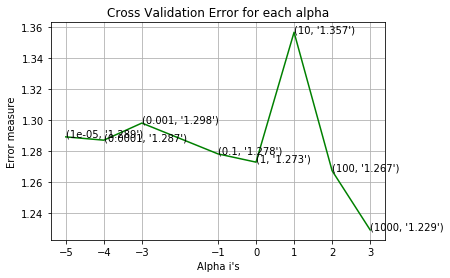

For values of best alpha =  1000 The train log loss is: 0.9177751513943047
For values of best alpha =  1000 The cross validation log loss is: 1.2289117222640726
For values of best alpha =  1000 The test log loss is: 1.20801220594264


In [18]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)


predict_y = sig_clf.predict_proba(train_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.1.1.2. Testing the model with best hyper paramters¶</h4>

Log Loss : 1.2289117222640726
Number of missclassified point : 0.4191729323308271
-------------------- Confusion matrix --------------------


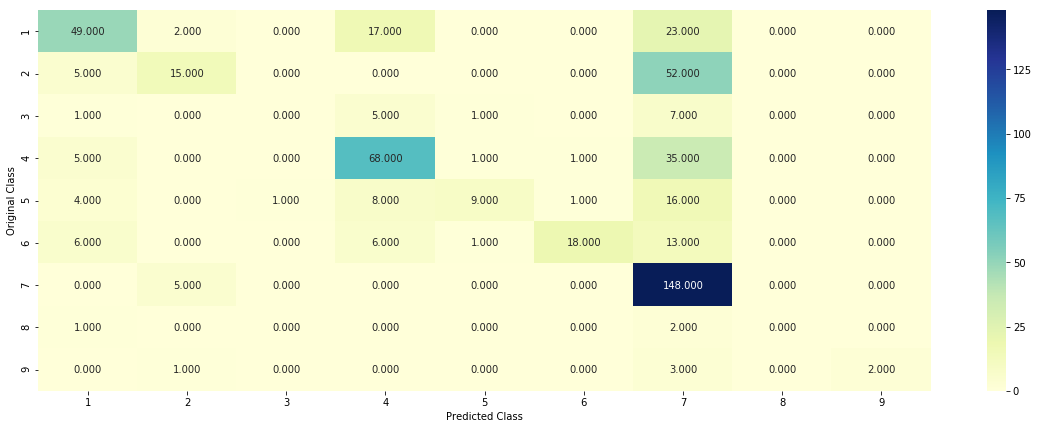

-------------------- Precision matrix (Columm Sum=1) --------------------


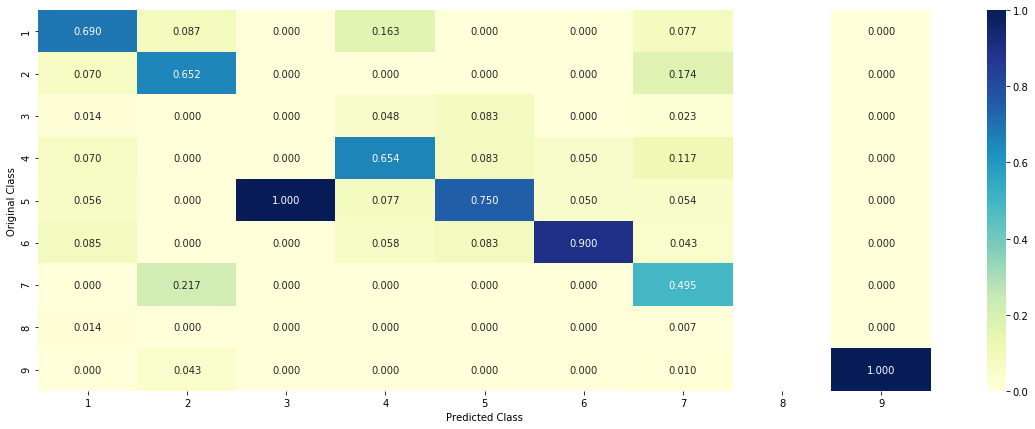

-------------------- Recall matrix (Row sum=1) --------------------


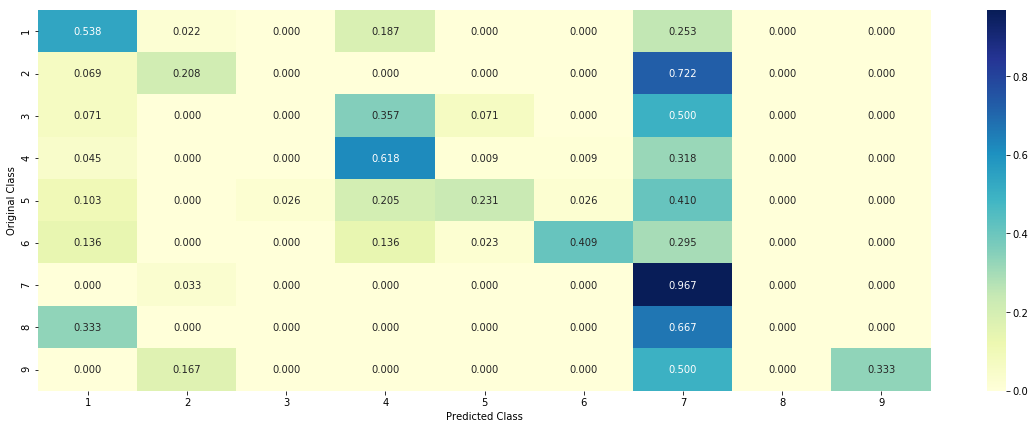

In [21]:
clf = MultinomialNB(alpha[best_alpha])
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_vec)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_vec)- cv_y[0]))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_vec))

<h4>4.1.1.3. Feature Importance, InCorrectly classified point</h4>

In [27]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y.iloc[test_point_index][0])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[7.527e-01 5.000e-03 6.000e-04 1.754e-01 1.050e-02 1.390e-02 4.100e-02
  9.000e-04 1.000e-04]]
Actual Class : 4
--------------------------------------------------
11 Text feature [type] present in test data point [True]
12 Text feature [wild] present in test data point [True]
13 Text feature [protein] present in test data point [True]
16 Text feature [one] present in test data point [True]
17 Text feature [dna] present in test data point [True]
18 Text feature [functions] present in test data point [True]
19 Text feature [binding] present in test data point [True]
20 Text feature [involved] present in test data point [True]
21 Text feature [two] present in test data point [True]
22 Text feature [role] present in test data point [True]
23 Text feature [also] present in test data point [True]
24 Text feature [therefore] present in test data point [True]
25 Text feature [results] present in test data point [True]
26 Text feature [affect]

<h4>4.1.1.4. Feature Importance, correctly classified point</h4>

In [28]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y.iloc[test_point_index][0])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[4.780e-02 2.900e-03 2.000e-04 1.310e-02 1.035e-01 8.261e-01 5.700e-03
  6.000e-04 0.000e+00]]
Actual Class : 6
--------------------------------------------------
5 Text feature [predicted] present in test data point [True]
6 Text feature [i124v] present in test data point [True]
7 Text feature [ivs5] present in test data point [True]
8 Text feature [brca] present in test data point [True]
9 Text feature [ivs13] present in test data point [True]
10 Text feature [odds] present in test data point [True]
11 Text feature [57] present in test data point [True]
12 Text feature [i2285v] present in test data point [True]
13 Text feature [personal] present in test data point [True]
14 Text feature [deleterious] present in test data point [True]
15 Text feature [basis] present in test data point [True]
16 Text feature [carry] present in test data point [True]
17 Text feature [expected] present in test data point [True]
18 Text feature [favor] p

<h2>4.2. K Nearest Neighbour Classification</h2>

<h3>4.2.1. Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.2416413470131202
for alpha = 11
Log Loss : 1.3362428747410415
for alpha = 15
Log Loss : 1.3647271441854134
for alpha = 21
Log Loss : 1.370152376845757
for alpha = 31
Log Loss : 1.383497289176948
for alpha = 41
Log Loss : 1.406194852815698
for alpha = 51
Log Loss : 1.4167390944071783
for alpha = 99
Log Loss : 1.380410118028794


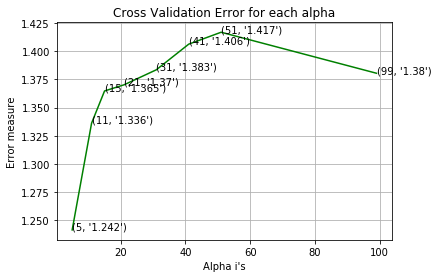

For values of best alpha =  5 The train log loss is: 0.9691078298934432
For values of best alpha =  5 The cross validation log loss is: 1.2416413470131202
For values of best alpha =  5 The test log loss is: 1.2209321797365928


In [12]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

predict_y = sig_clf.predict_proba(train_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

<h3>4.2.2. Testing the model with best hyper paramters</h3>

Log loss : 1.2416413470131202
Number of mis-classified points : 0.4342105263157895
-------------------- Confusion matrix --------------------


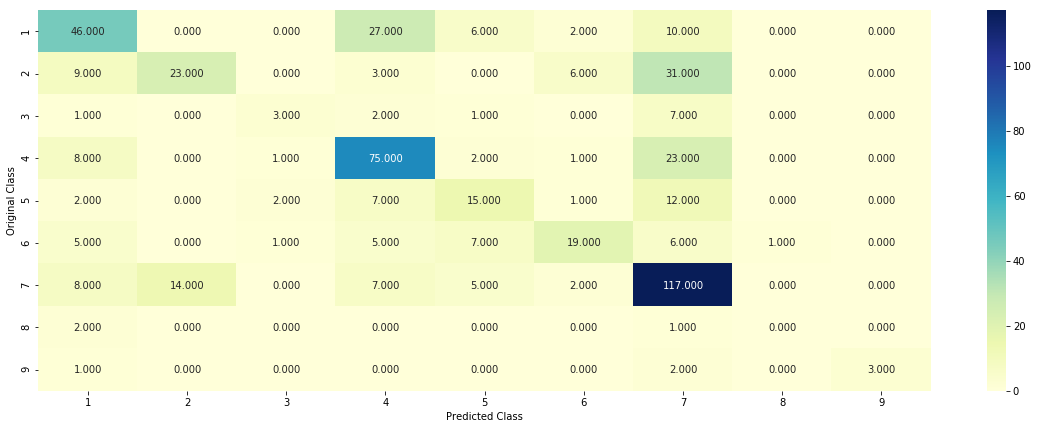

-------------------- Precision matrix (Columm Sum=1) --------------------


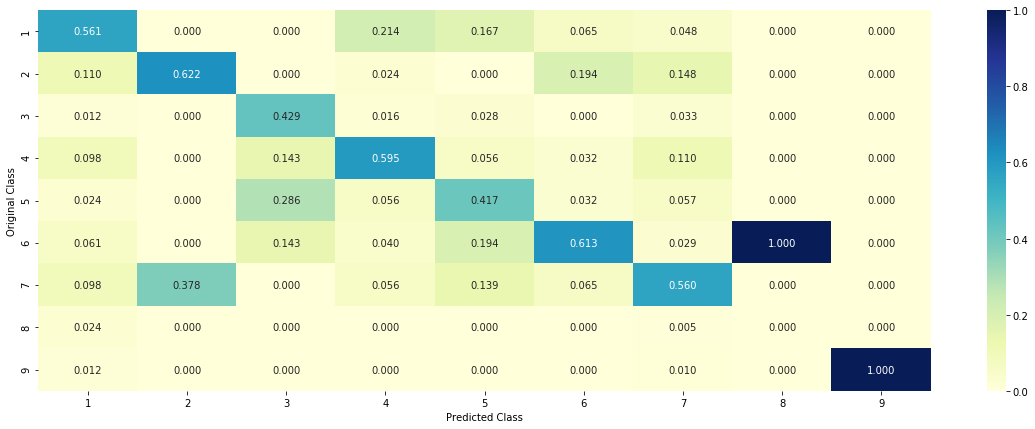

-------------------- Recall matrix (Row sum=1) --------------------


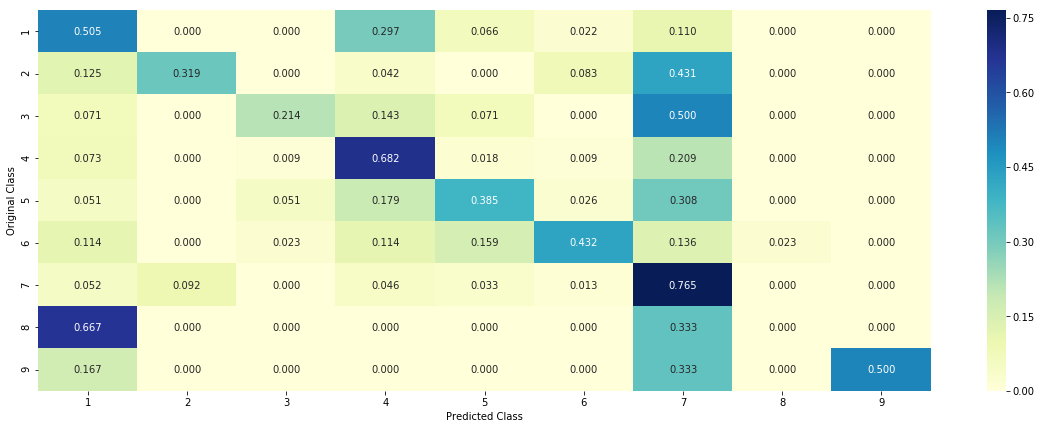

In [18]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_vec, train_y, cv_x_vec, cv_y, clf)

<h3>4.2.3.Sample Query point -1 </h3>

In [19]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_vec[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_vec[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 4
The  5  nearest neighbours of the test points belongs to classes [1 1 1 1 1]
Fequency of nearest points : Counter({1: 5})


<h3>4.2.4. Sample Query Point-2 </h3>

In [20]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_vec[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_vec[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 6
Actual Class : 6
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [6 6 6 6 6]
Fequency of nearest points : Counter({6: 5})


<h2>4.3. Logistic Regression</h2>

<h3>4.3.1. With Class balancing</h3>

<h4>4.3.1.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.4291313782714807
for alpha = 1e-05
Log Loss : 1.4095021719934864
for alpha = 0.0001
Log Loss : 1.3129774433000991
for alpha = 0.001
Log Loss : 1.1213516208974583
for alpha = 0.01
Log Loss : 1.0899374724966169
for alpha = 0.1
Log Loss : 1.1804420155559923
for alpha = 1
Log Loss : 1.4226785896094787
for alpha = 10
Log Loss : 1.4641184465815391
for alpha = 100
Log Loss : 1.468568556157318


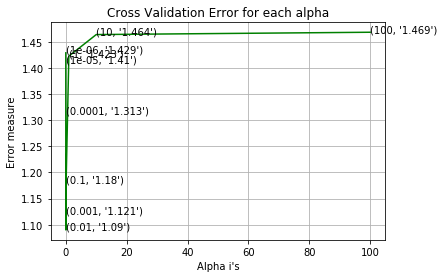

For values of best alpha =  0.01 The train log loss is: 0.6556891650382015
For values of best alpha =  0.01 The cross validation log loss is: 1.0899374724966169
For values of best alpha =  0.01 The test log loss is: 1.0984357539485208


In [19]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.3.1.2. Testing the model with best hyper paramters</h4>

Log loss : 1.0899374724966169
Number of mis-classified points : 0.3458646616541353
-------------------- Confusion matrix --------------------


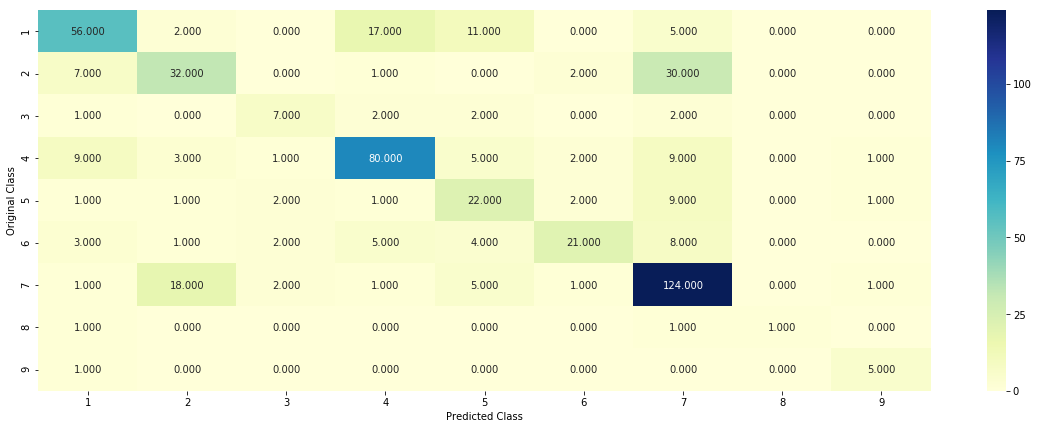

-------------------- Precision matrix (Columm Sum=1) --------------------


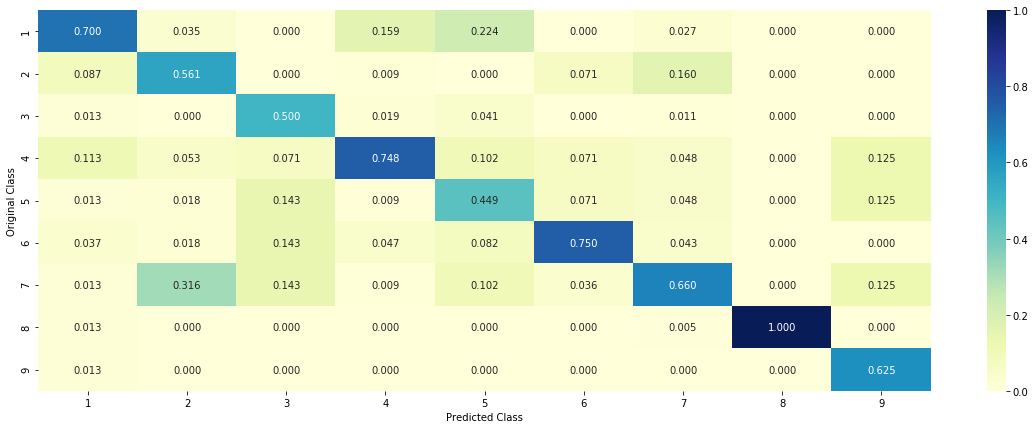

-------------------- Recall matrix (Row sum=1) --------------------


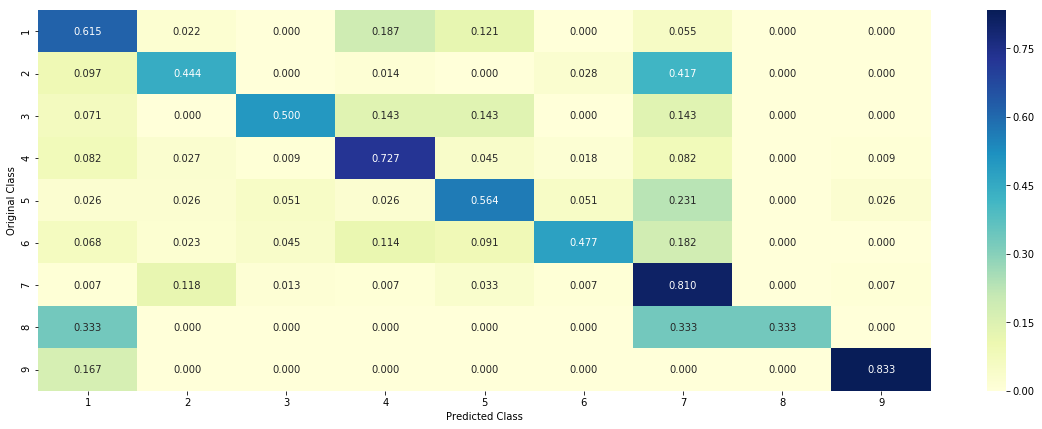

In [22]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_vec, train_y, cv_x_vec, cv_y, clf)

<h4>4.3.1.3. Feature Importance</h4>

In [23]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_tfidfvector.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h4>4.3.1.3.1. InCorrectly Classified point</h4>

In [24]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vec,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[9.753e-01 1.500e-03 8.000e-04 1.420e-02 3.000e-03 2.800e-03 1.100e-03
  1.300e-03 1.000e-04]]
Actual Class : 4
--------------------------------------------------
15 Text feature [aggregation] present in test data point [True]
17 Text feature [20th] present in test data point [True]
19 Text feature [tetramerization] present in test data point [True]
20 Text feature [endonucleases] present in test data point [True]
37 Text feature [controller] present in test data point [True]
83 Text feature [breakage] present in test data point [True]
101 Text feature [aggregates] present in test data point [True]
208 Text feature [g334] present in test data point [True]
210 Text feature [metamorph] present in test data point [True]
246 Text feature [destabilized] present in test data point [True]
272 Text feature [l344p] present in test data point [True]
279 Text feature [a347g] present in test data point [True]
280 Text feature [d352h] present in t

<h5>4.3.1.3.2. Correctly Classified point</

In [25]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[4.000e-04 2.000e-04 2.000e-04 2.000e-04 1.630e-02 9.822e-01 0.000e+00
  5.000e-04 0.000e+00]]
Actual Class : 6
--------------------------------------------------
4 Text feature [ivs13] present in test data point [True]
7 Text feature [i2285v] present in test data point [True]
31 Text feature [fell] present in test data point [True]
34 Text feature [brca] present in test data point [True]
122 Text feature [ivs5] present in test data point [True]
125 Text feature [ivs8] present in test data point [True]
141 Text feature [ivs2] present in test data point [True]
166 Text feature [951] present in test data point [True]
217 Text feature [histopathology] present in test data point [True]
222 Text feature [odds] present in test data point [True]
250 Text feature [910] present in test data point [True]
287 Text feature [m1652t] present in test data point [True]
299 Text feature [i124v] present in test data point [True]
315 Text feature [ethni

<h3>4.3.2. Without Class balancing</h3>

<h4>4.3.2.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.375121719606184
for alpha = 1e-05
Log Loss : 1.3612055746469787
for alpha = 0.0001
Log Loss : 1.3687057930706632
for alpha = 0.001
Log Loss : 1.1522055558306348
for alpha = 0.01
Log Loss : 1.1542231101385998
for alpha = 0.1
Log Loss : 1.2119563810108218
for alpha = 1
Log Loss : 1.4001214123246428


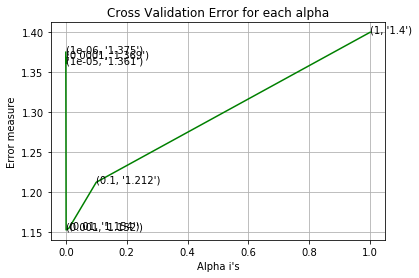

For values of best alpha =  0.001 The train log loss is: 0.5753039736624821
For values of best alpha =  0.001 The cross validation log loss is: 1.1522055558306348
For values of best alpha =  0.001 The test log loss is: 1.0575542740838857


In [26]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

predict_y = sig_clf.predict_proba(train_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.3.2.2. Testing model with best hyper parameters</h4>

Log loss : 1.1522055558306348
Number of mis-classified points : 0.37218045112781956
-------------------- Confusion matrix --------------------


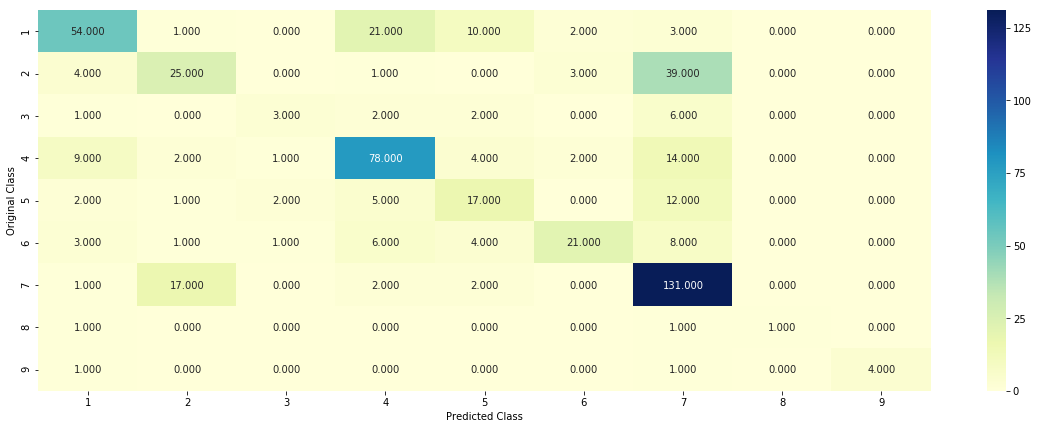

-------------------- Precision matrix (Columm Sum=1) --------------------


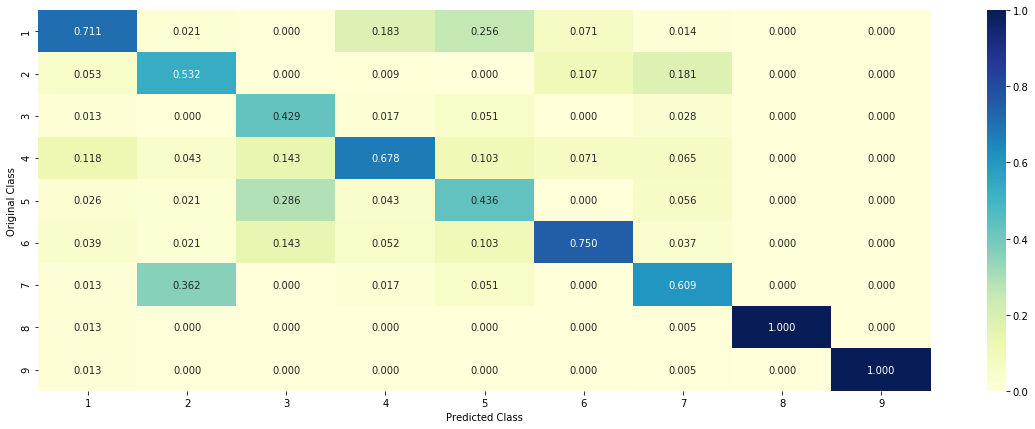

-------------------- Recall matrix (Row sum=1) --------------------


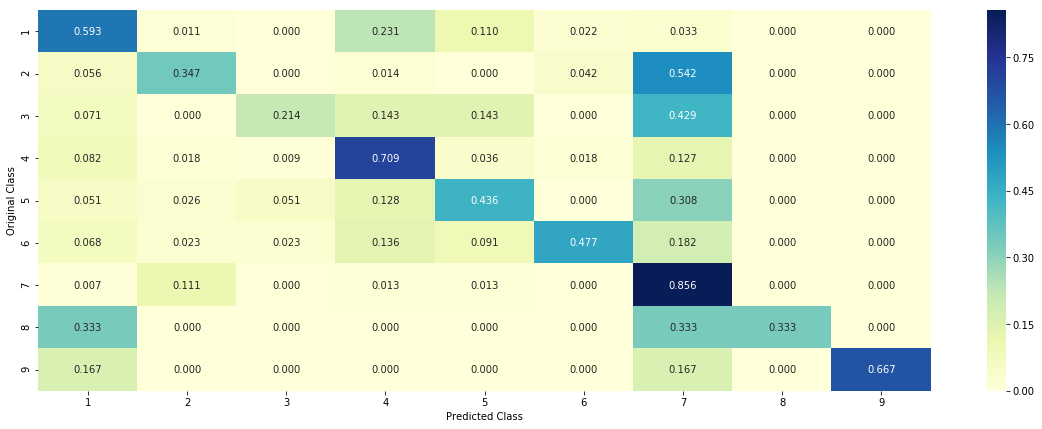

In [27]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_vec, train_y, cv_x_vec, cv_y, clf)

<h5>4.3.2.3. Feature Importance, InCorrectly Classified point</h5>

In [28]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vec,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[9.421e-01 9.100e-03 7.000e-04 2.200e-02 5.400e-03 4.000e-03 1.570e-02
  1.000e-03 0.000e+00]]
Actual Class : 4
--------------------------------------------------
150 Text feature [ws] present in test data point [True]
159 Text feature [endonucleases] present in test data point [True]
196 Text feature [hpv] present in test data point [True]
298 Text feature [tsa] present in test data point [True]
390 Text feature [aggregation] present in test data point [True]
466 Text feature [assemble] present in test data point [True]
Out of the top  500  features  6 are present in query point


<h5>4.3.2.4. Feature Importance, Correctly Classified point</h5>

In [29]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[6.500e-03 4.100e-03 3.000e-04 2.800e-03 6.210e-02 9.214e-01 2.200e-03
  6.000e-04 0.000e+00]]
Actual Class : 6
--------------------------------------------------
235 Text feature [910] present in test data point [True]
298 Text feature [v1804d] present in test data point [True]
375 Text feature [ivs13] present in test data point [True]
390 Text feature [951] present in test data point [True]
410 Text feature [fell] present in test data point [True]
Out of the top  500  features  5 are present in query point


<h2>4.4. Linear Support Vector Machines</h2>

<h3>4.4.1. Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.4066299005687786
for C = 0.0001
Log Loss : 1.3878341636210978
for C = 0.001
Log Loss : 1.3041683260474701
for C = 0.01
Log Loss : 1.1467362685143216
for C = 0.1
Log Loss : 1.1694504747328491
for C = 1
Log Loss : 1.4693417864631741
for C = 10
Log Loss : 1.4693548016173377
for C = 100
Log Loss : 1.4693547567622132


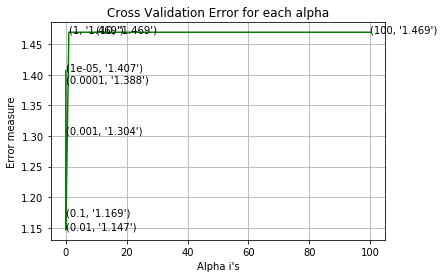

For values of best alpha =  0.01 The train log loss is: 0.6975487292216426
For values of best alpha =  0.01 The cross validation log loss is: 1.1467362685143216
For values of best alpha =  0.01 The test log loss is: 1.0939934371675357


In [35]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidfvector)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

predict_y = sig_clf.predict_proba(train_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

<h3>4.4.2. Testing model with best hyper parameters</h3>

Log loss : 1.1467362685143216
Number of mis-classified points : 0.37406015037593987
-------------------- Confusion matrix --------------------


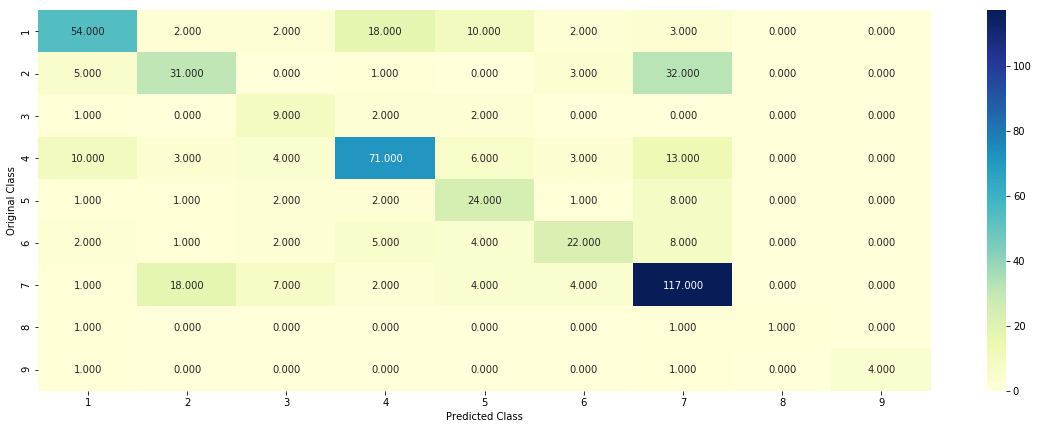

-------------------- Precision matrix (Columm Sum=1) --------------------


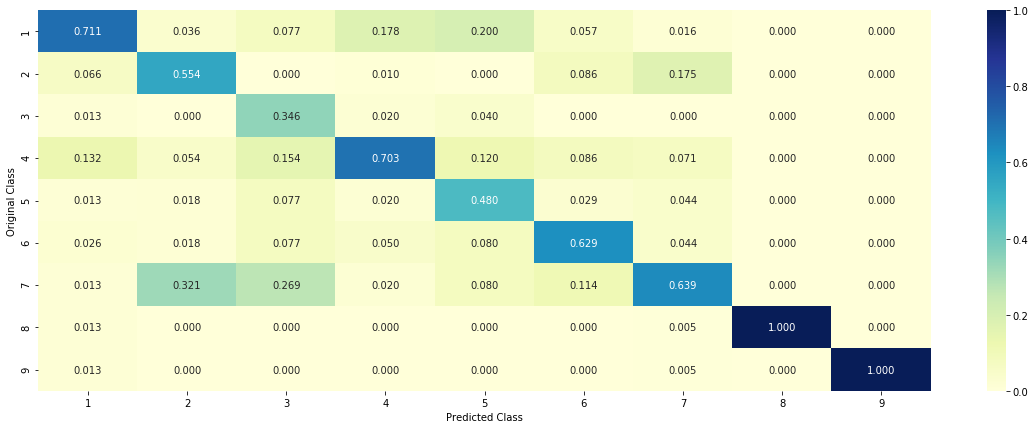

-------------------- Recall matrix (Row sum=1) --------------------


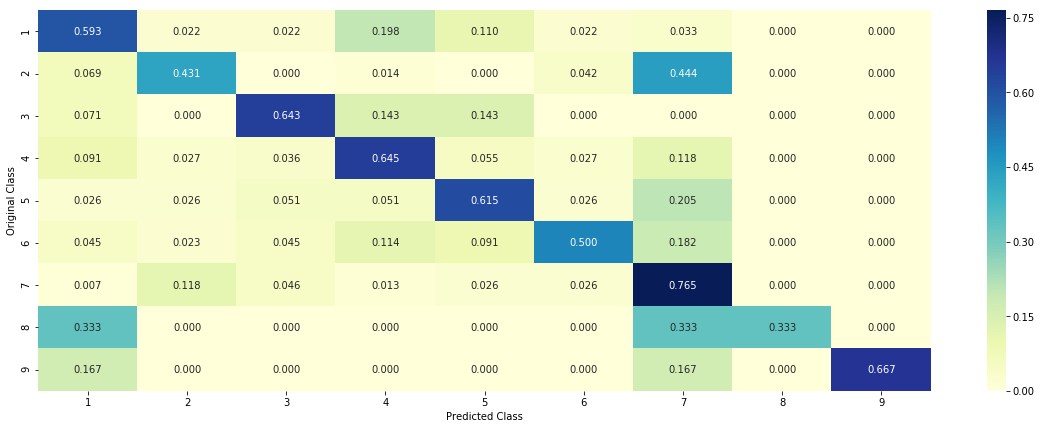

In [36]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_vec, train_y, cv_x_vec,cv_y, clf)

<h3>4.3.3. Feature Importance¶</h3>

<h5>4.3.3.1. For InCorrectly classified point</h5>

In [37]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_vec,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[9.103e-01 1.090e-02 2.700e-03 3.810e-02 1.260e-02 3.300e-03 1.900e-02
  2.200e-03 9.000e-04]]
Actual Class : 4
--------------------------------------------------
84 Text feature [breakage] present in test data point [True]
87 Text feature [endonucleases] present in test data point [True]
135 Text feature [aggregation] present in test data point [True]
260 Text feature [rb1] present in test data point [True]
336 Text feature [aggregates] present in test data point [True]
353 Text feature [r2] present in test data point [True]
370 Text feature [4j] present in test data point [True]
410 Text feature [assemble] present in test data point [True]
437 Text feature [ws] present in test data point [True]
Out of the top  500  features  9 are present in query point


<h5>4.3.3.2. For Correctly classified point</h5>

In [38]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0162 0.0153 0.004  0.0214 0.024  0.8999 0.0163 0.0021 0.0009]]
Actual Class : 6
--------------------------------------------------
13 Text feature [ivs13] present in test data point [True]
52 Text feature [fell] present in test data point [True]
61 Text feature [i2285v] present in test data point [True]
118 Text feature [brca] present in test data point [True]
132 Text feature [951] present in test data point [True]
189 Text feature [ivs2] present in test data point [True]
195 Text feature [ivs8] present in test data point [True]
197 Text feature [histopathology] present in test data point [True]
225 Text feature [ivs5] present in test data point [True]
226 Text feature [traces] present in test data point [True]
463 Text feature [models] present in test data point [True]
Out of the top  500  features  11 are present in query point


<h2>4.5 Random Forest Classifier</h2>

<h3>4.5.1. Hyper paramter tuning</h3>

In [40]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_vec, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_vec, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_vec)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

predict_y = sig_clf.predict_proba(train_x_vec)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vec)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vec)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2324214072234014
for n_estimators = 100 and max depth =  10
Log Loss : 1.1742581513649217
for n_estimators = 200 and max depth =  5
Log Loss : 1.2135099061079933
for n_estimators = 200 and max depth =  10
Log Loss : 1.162168276946401
for n_estimators = 500 and max depth =  5
Log Loss : 1.2019616806186963
for n_estimators = 500 and max depth =  10
Log Loss : 1.1505172386957137
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2039728832845713
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1520496059829919
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1976124888190527
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1489755092440446
For values of best estimator =  2000 The train log loss is: 0.6366562064998343
For values of best estimator =  2000 The cross validation log loss is: 1.1489755092440448
For values of best estimator =  2000 The test log loss is: 1.134660138309635


<h3>4.5.2. Testing model with best hyper parameters </h3>

Log loss : 1.1489755092440448
Number of mis-classified points : 0.38345864661654133
-------------------- Confusion matrix --------------------


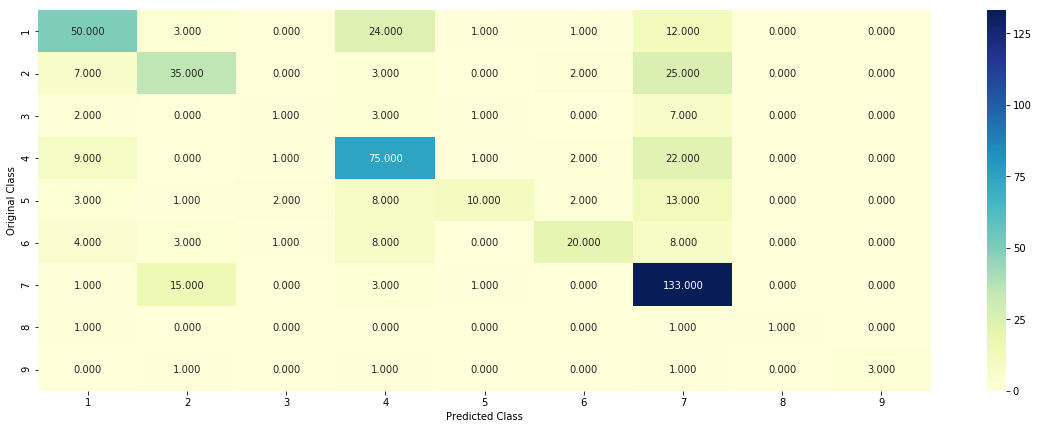

-------------------- Precision matrix (Columm Sum=1) --------------------


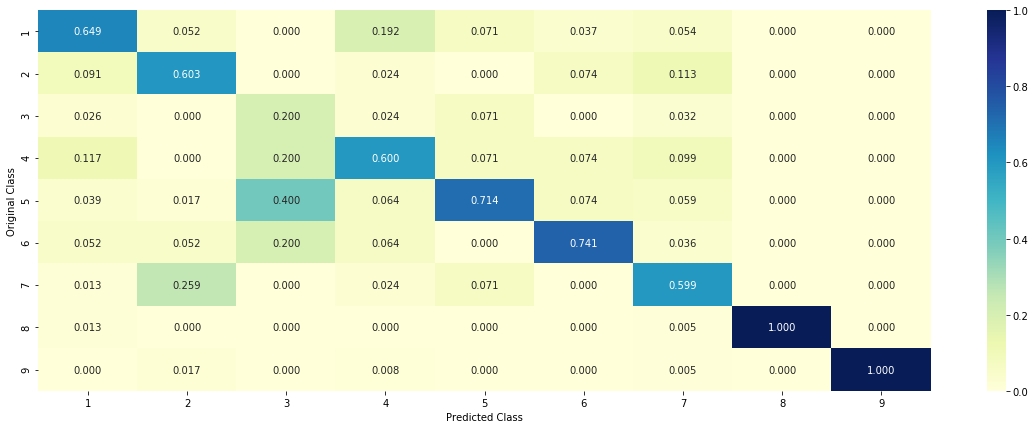

-------------------- Recall matrix (Row sum=1) --------------------


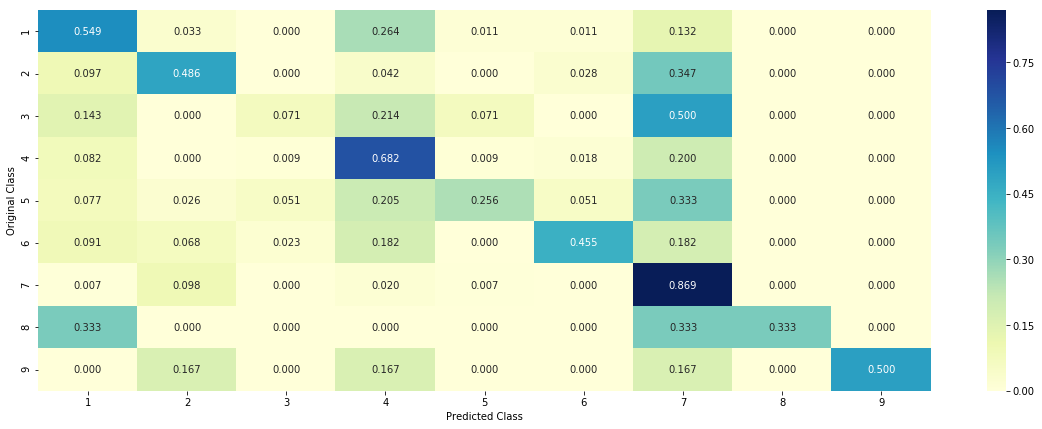

In [43]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_tfidfvector, train_y,cv_x_tfidfvector,cv_y, clf)

<h3>4.5.3. Feature Importance</h3>

<h5>4.5.3.1. InCorrectly Classified point</h5>

In [44]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.6041 0.0346 0.0146 0.1962 0.0455 0.0404 0.0521 0.0063 0.0064]]
Actual Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [activated] present in test data point [True]
3 Text feature [tyrosine] present in test data point [True]
5 Text feature [activation] present in test data point [True]
6 Text feature [inhibitor] present in test data point [True]
7 Text feature [signaling] present in test data point [True]
8 Text feature [function] present in test data point [True]
9 Text feature [phosphorylation] present in test data point [True]
10 Text feature [growth] present in test data point [True]
12 Text feature [treatment] present in test data point [True]
13 Text feature [constitutive] present in test data point [True]
14 Text feature [suppressor] present in test data point [True]
15 Text featu

<h5>4.5.3.2. Correctly Classified point</h5>

In [45]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0177 0.01   0.01   0.0147 0.0797 0.8539 0.0098 0.0012 0.003 ]]
Actuall Class : 6
--------------------------------------------------
5 Text feature [activation] present in test data point [True]
8 Text feature [function] present in test data point [True]
19 Text feature [loss] present in test data point [True]
26 Text feature [therapeutic] present in test data point [True]
27 Text feature [missense] present in test data point [True]
29 Text feature [protein] present in test data point [True]
32 Text feature [deleterious] present in test data point [True]
35 Text feature [cells] present in test data point [True]
36 Text feature [functional] present in test data point [True]
37 Text feature [variants] present in test data point [True]
41 Text feature [yeast] present in test data point [True]
43 Text feature [pathogenic] present in test data point [True]
46 Text feature [amplification] present in test data point [True]
49 Text feature 

<h2>4.7 Stack the models </h2>

<h3>4.7.1 testing with hyper parameter tuning</h3>

In [46]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_vec, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_vec, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_vec, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_vec, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_vec))))
sig_clf2.fit(train_x_vec, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_vec))))
sig_clf3.fit(train_x_vec, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_vec))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_vec, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_vec))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_vec))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.09
Support vector machines : Log Loss: 1.47
Naive Bayes : Log Loss: 1.30
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.038
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.520
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.143
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.244
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.461


<h3>4.7.2 testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.6425317386387405
Log loss (CV) on the stacking classifier : 1.1426780294577432
Log loss (test) on the stacking classifier : 1.136030220969642
Number of missclassified point : 0.38345864661654133
-------------------- Confusion matrix --------------------


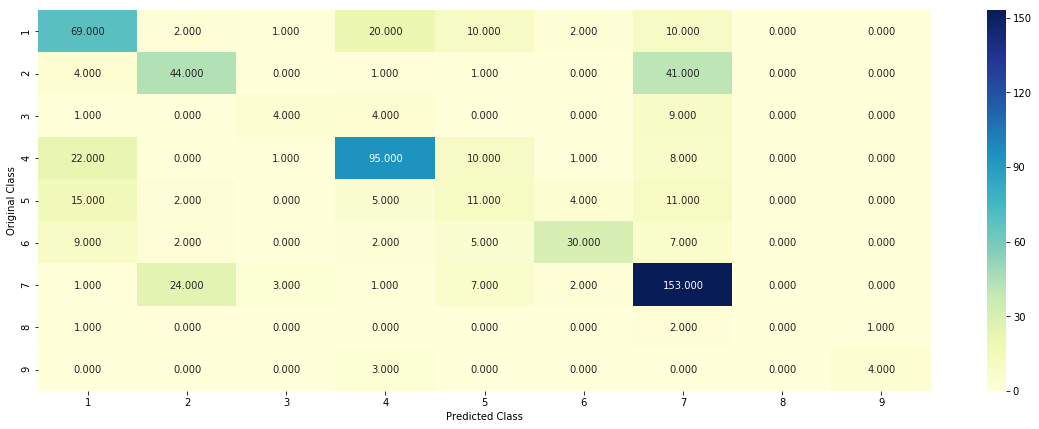

-------------------- Precision matrix (Columm Sum=1) --------------------


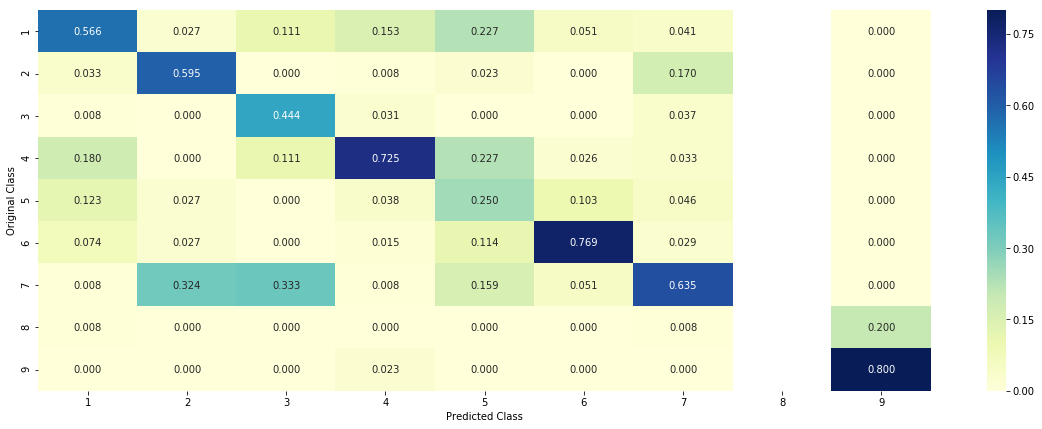

-------------------- Recall matrix (Row sum=1) --------------------


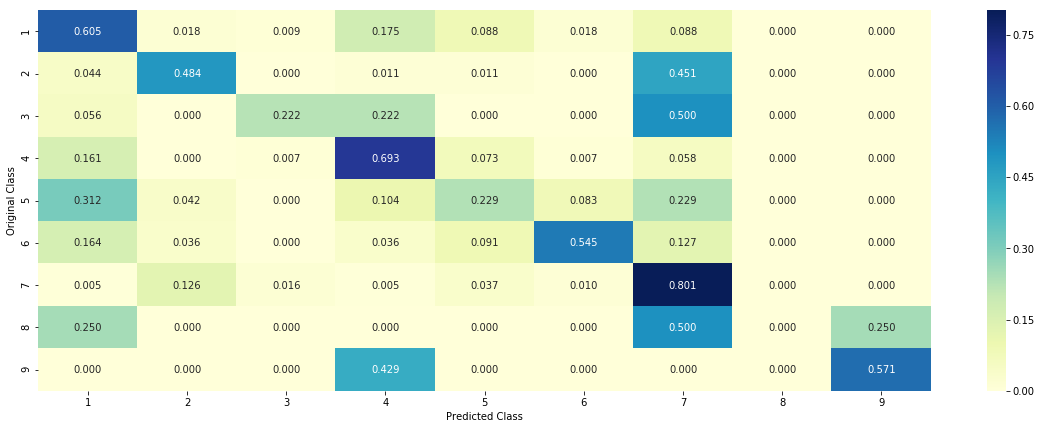

In [47]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_vec, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_vec))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_vec))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_vec))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_vec)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_vec))

<h3>4.7.3 Maximum Voting classifier</h3>

Log loss (train) on the VotingClassifier : 0.8602485502514741
Log loss (CV) on the VotingClassifier : 1.149649034138008
Log loss (test) on the VotingClassifier : 1.147667566896197
Number of missclassified point : 0.3804511278195489
-------------------- Confusion matrix --------------------


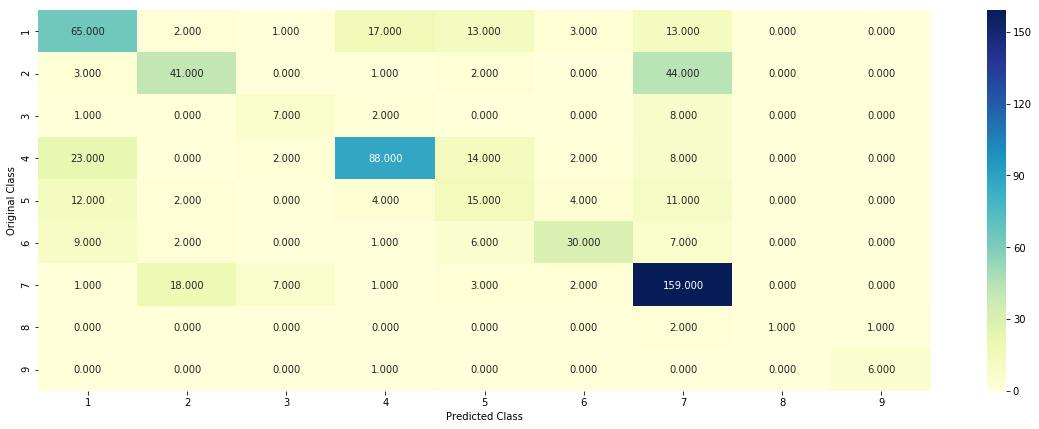

-------------------- Precision matrix (Columm Sum=1) --------------------


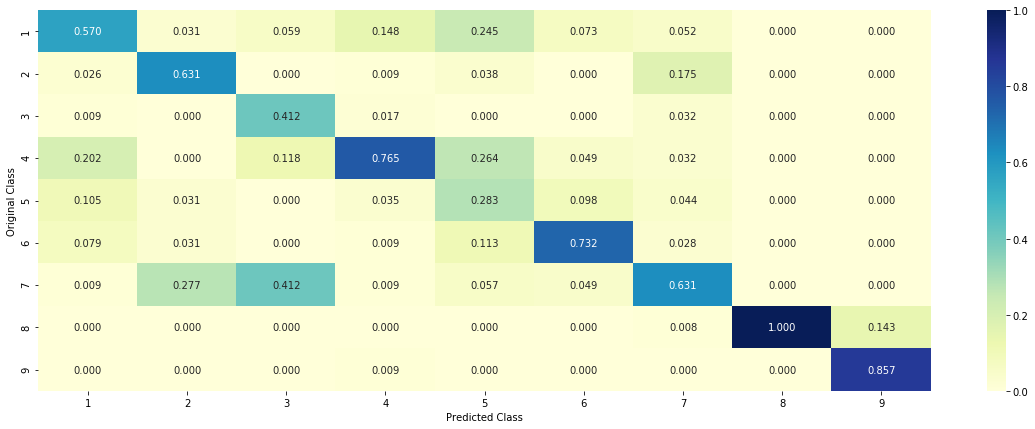

-------------------- Recall matrix (Row sum=1) --------------------


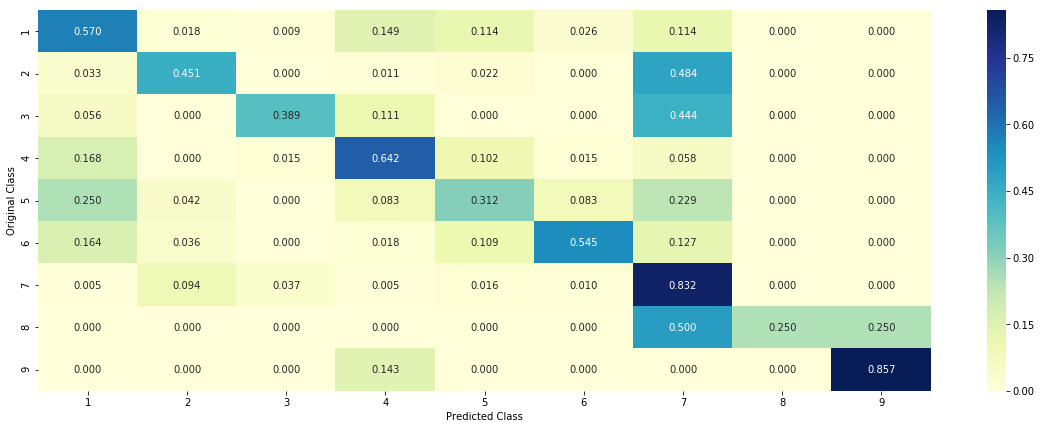

In [48]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_vec, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_vec)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_vec)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_vec)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_vec)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_vec))

<h1>2)Instead of using all the words in the dataset, use only the top 1000 words based of tf-idf values</h1>

In [54]:
train_x_vec = train_x_tfidfvector
test_x_vec = test_x_tfidfvector
cv_x_vec = cv_x_tfidfvector

In [55]:
print(train_x_vec.shape)
print(test_x_vec.shape)
print(cv_x_vec.shape)

(2124, 3178)
(665, 3178)
(532, 3178)


<h2>4.1. Base Line Model</h2>

<h3>4.1.1. Naive Bayes</h3>

<h5>4.1.1.1. Hyper parameter tuning</h5>

for alpha = 1e-05
Log Loss : 1.1546505400408336
for alpha = 0.0001
Log Loss : 1.1542824141078136
for alpha = 0.001
Log Loss : 1.1527802991777365
for alpha = 0.1
Log Loss : 1.1749628073763099
for alpha = 1
Log Loss : 1.2830465900676107
for alpha = 10
Log Loss : 1.4938217673860965
for alpha = 100
Log Loss : 1.4765498820128002
for alpha = 1000
Log Loss : 1.4603192065813801


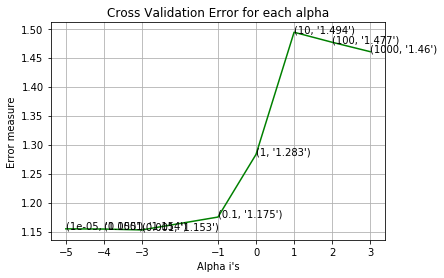

For values of best alpha =  0.001 The train log loss is: 0.5240007203668147
For values of best alpha =  0.001 The cross validation log loss is: 1.1527802991777365
For values of best alpha =  0.001 The test log loss is: 1.236249812084988


In [57]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)


predict_y = sig_clf.predict_proba(train_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))



<h6>4.1.1.2. Testing the model with best hyper paramters</h6>

Log Loss : 1.1527802991777365
Number of missclassified point : 0.36466165413533835
-------------------- Confusion matrix --------------------


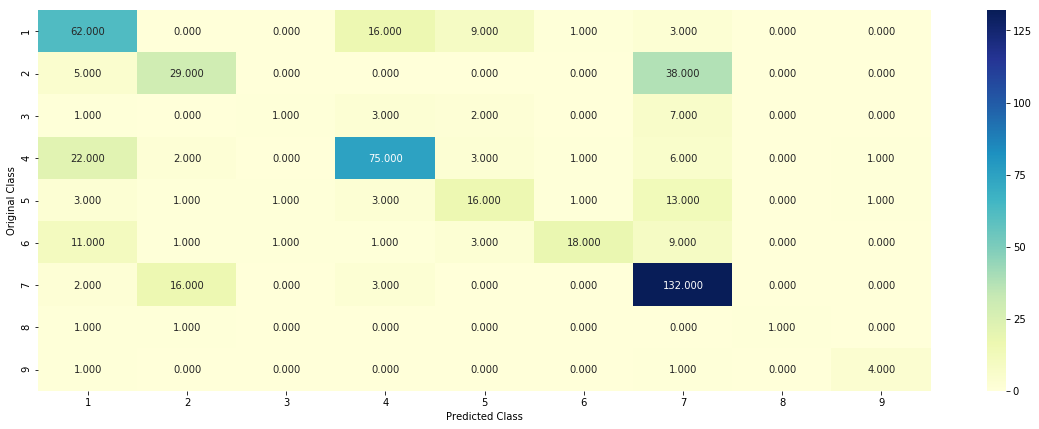

-------------------- Precision matrix (Columm Sum=1) --------------------


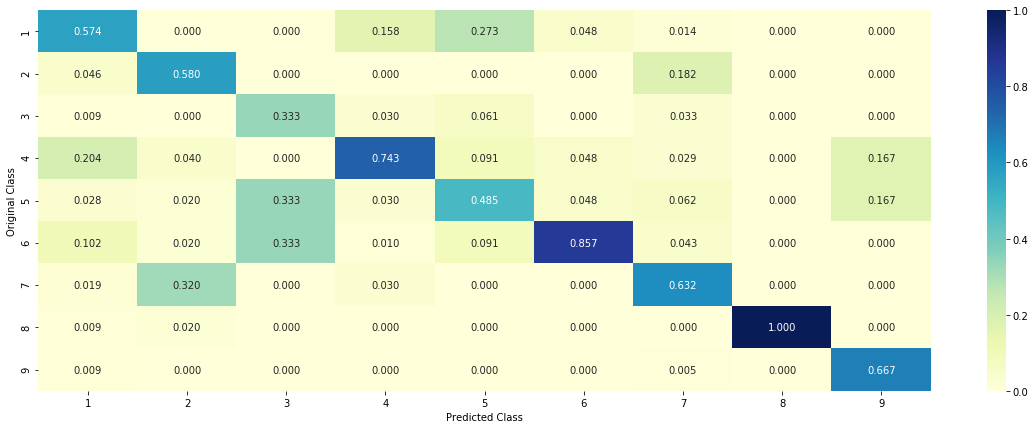

-------------------- Recall matrix (Row sum=1) --------------------


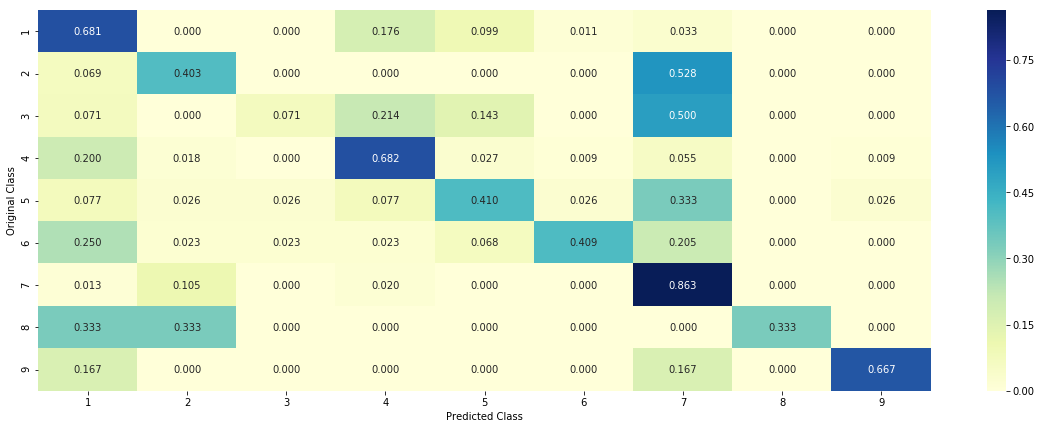

In [58]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_vec)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_vec)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_vec.toarray()))

<h5>4.1.1.3. Feature Importance, InCorrectly classified point</h5>

In [59]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.4824 0.0471 0.0114 0.2814 0.0355 0.0344 0.1021 0.0032 0.0025]]
Actual Class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


<h5>4.1.1.4. Feature Importance, Correctly classified point</h5>

In [60]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0524 0.0403 0.0097 0.0636 0.0303 0.7115 0.0873 0.0027 0.0022]]
Actual Class : 6
--------------------------------------------------
16 Text feature [114] present in test data point [True]
21 Text feature [00] present in test data point [True]
30 Text feature [105] present in test data point [True]
50 Text feature [1010] present in test data point [True]
70 Text feature [121] present in test data point [True]
86 Text feature [11] present in test data point [True]
95 Text feature [001] present in test data point [True]
Out of the top  100  features  7 are present in query point


<h2>4.2. K Nearest Neighbour Classification</h2>

<h3>4.2.1. Hyper parameter tuning¶</h3>

for alpha = 5
Log Loss : 1.0613353028642343
for alpha = 11
Log Loss : 1.0995864217491116
for alpha = 15
Log Loss : 1.1165385893089235
for alpha = 21
Log Loss : 1.1369257804236934
for alpha = 31
Log Loss : 1.1671764542787288
for alpha = 41
Log Loss : 1.194312315375352
for alpha = 51
Log Loss : 1.2122602519434806
for alpha = 99
Log Loss : 1.2877951048447212


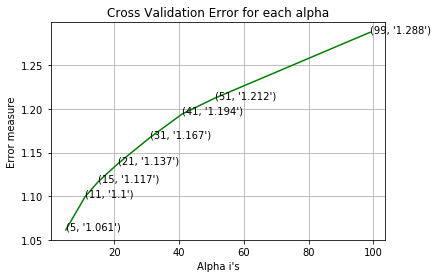

For values of best alpha =  5 The train log loss is: 0.8688622258999213
For values of best alpha =  5 The cross validation log loss is: 1.0613353028642343
For values of best alpha =  5 The test log loss is: 1.0761741345921636


In [63]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

predict_y = sig_clf.predict_proba(train_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))



<h3>4.2.2. Testing the model with best hyper paramters</h3>

Log loss : 1.0613353028642343
Number of mis-classified points : 0.37030075187969924
-------------------- Confusion matrix --------------------


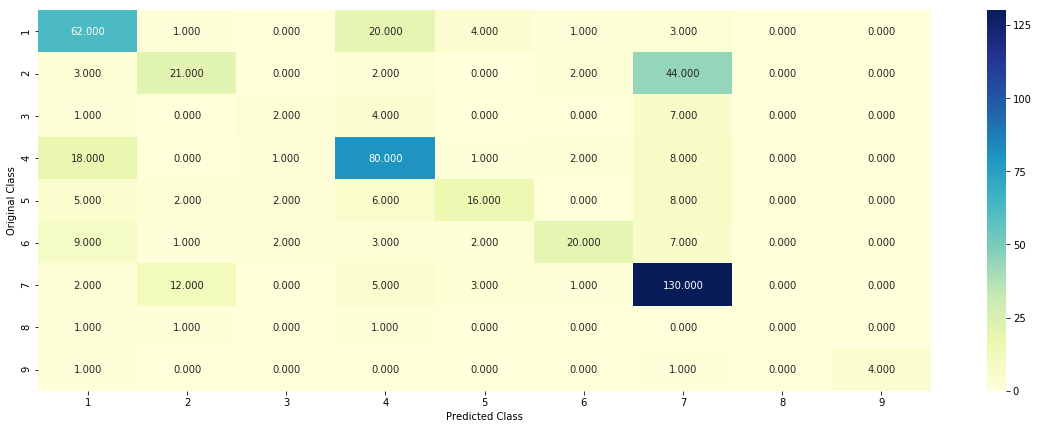

-------------------- Precision matrix (Columm Sum=1) --------------------


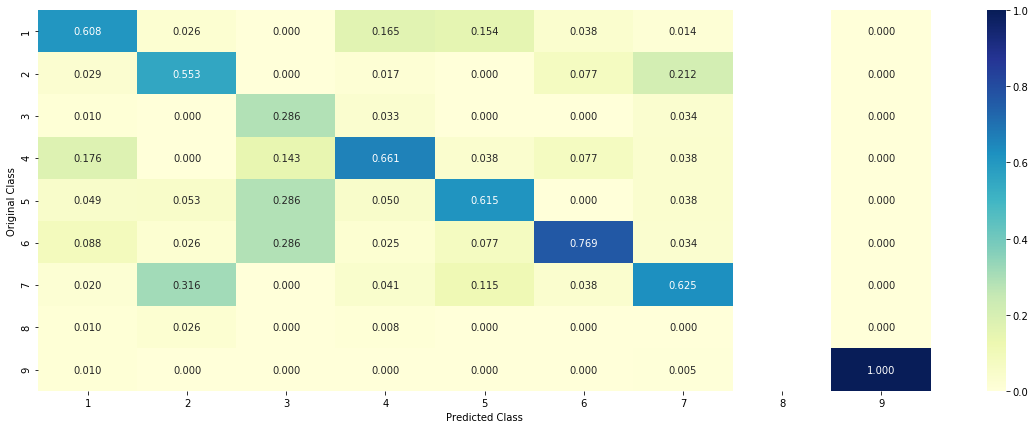

-------------------- Recall matrix (Row sum=1) --------------------


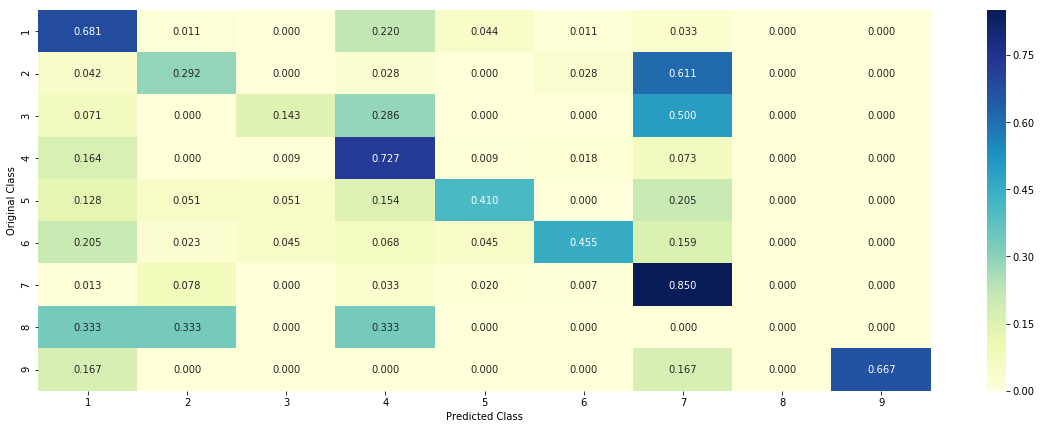

In [64]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_vec, train_y, cv_x_vec, cv_y, clf)

<h3>4.2.3.Sample Query point -1</h3>

In [65]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_vec[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_vec[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 4
The  5  nearest neighbours of the test points belongs to classes [1 1 1 1 1]
Fequency of nearest points : Counter({1: 5})


<h3>4.2.4. Sample Query Point-2</h3>

In [66]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_vec[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_vec[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 6
Actual Class : 6
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [6 6 6 6 6]
Fequency of nearest points : Counter({6: 5})


<h2>4.3. Logistic Regression</h2>

<h3>4.3.1. With Class balancing</h3>

<h4>4.3.1.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.4291313782714807
for alpha = 1e-05
Log Loss : 1.4095021719934864
for alpha = 0.0001
Log Loss : 1.3129774433000991
for alpha = 0.001
Log Loss : 1.1213516208974583
for alpha = 0.01
Log Loss : 1.0899374724966169
for alpha = 0.1
Log Loss : 1.1804420155559923
for alpha = 1
Log Loss : 1.4226785896094787
for alpha = 10
Log Loss : 1.4641184465815391
for alpha = 100
Log Loss : 1.468568556157318


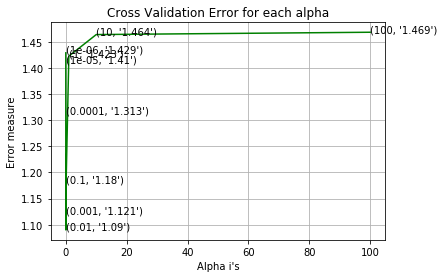

For values of best alpha =  0.01 The train log loss is: 0.6556891650382015
For values of best alpha =  0.01 The cross validation log loss is: 1.0899374724966169
For values of best alpha =  0.01 The test log loss is: 1.0984357539485208


In [30]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

predict_y = sig_clf.predict_proba(train_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

<h5>4.3.1.2. Testing the model with best hyper paramters</h5>

Log loss : 1.0899374724966169
Number of mis-classified points : 0.3458646616541353
-------------------- Confusion matrix --------------------


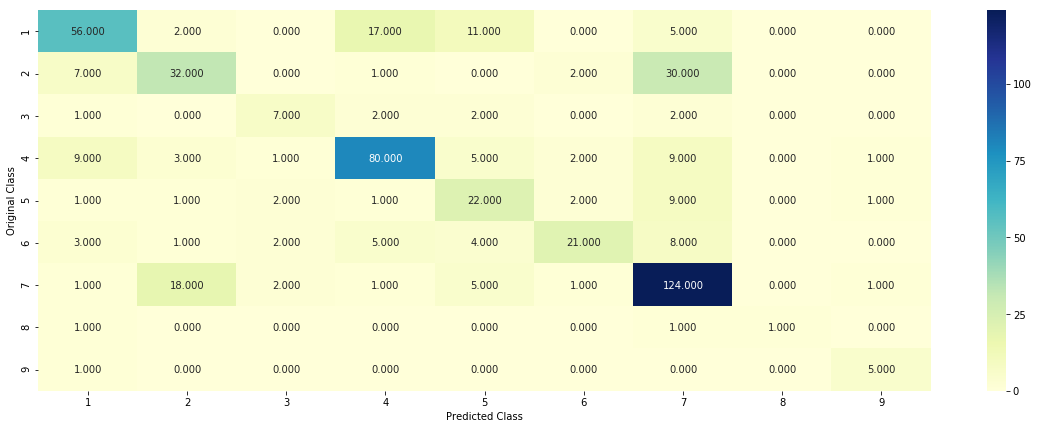

-------------------- Precision matrix (Columm Sum=1) --------------------


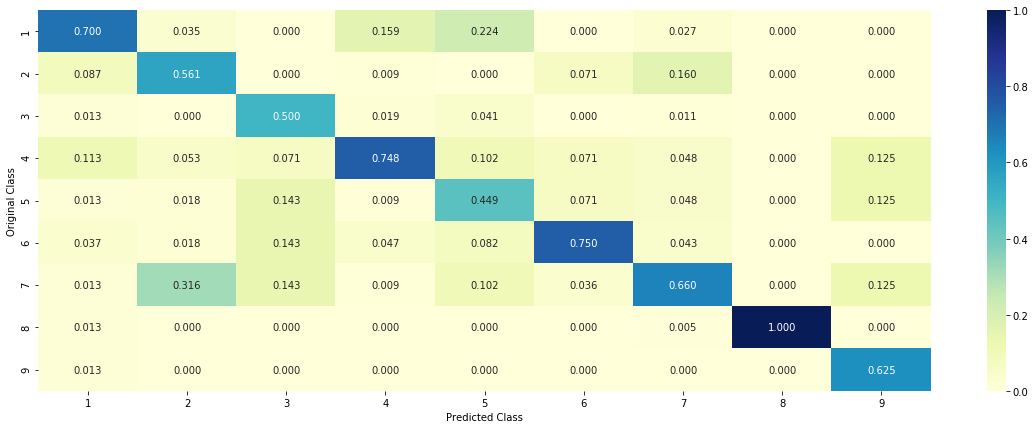

-------------------- Recall matrix (Row sum=1) --------------------


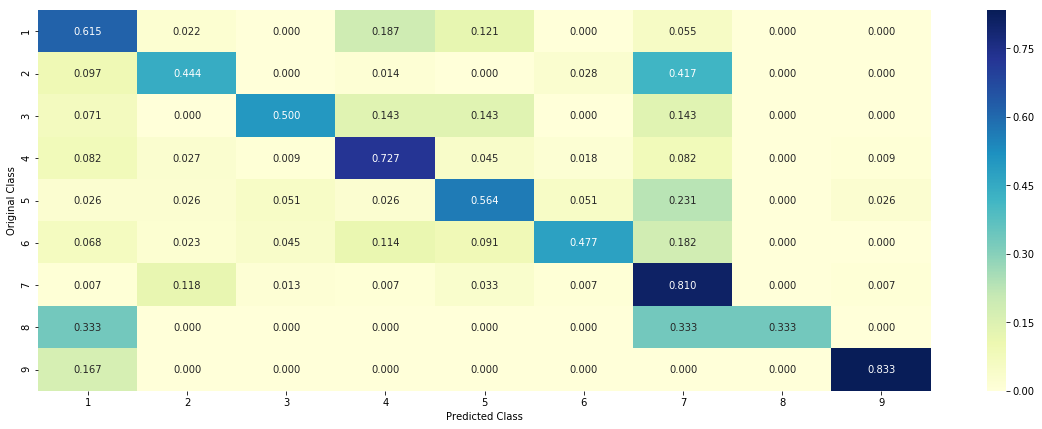

In [31]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_vec, train_y, cv_x_vec, cv_y, clf)

<h4>4.3.1.3. Feature Importance</h4>

In [32]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_tfidfvector.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h5>4.3.1.3.1. InCorrectly Classified point</h5>

In [33]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vec,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[9.753e-01 1.500e-03 8.000e-04 1.420e-02 3.000e-03 2.800e-03 1.100e-03
  1.300e-03 1.000e-04]]
Actual Class : 4
--------------------------------------------------
15 Text feature [aggregation] present in test data point [True]
17 Text feature [20th] present in test data point [True]
19 Text feature [tetramerization] present in test data point [True]
20 Text feature [endonucleases] present in test data point [True]
37 Text feature [controller] present in test data point [True]
83 Text feature [breakage] present in test data point [True]
101 Text feature [aggregates] present in test data point [True]
208 Text feature [g334] present in test data point [True]
210 Text feature [metamorph] present in test data point [True]
246 Text feature [destabilized] present in test data point [True]
272 Text feature [l344p] present in test data point [True]
279 Text feature [a347g] present in test data point [True]
280 Text feature [d352h] present in t

<h5>4.3.1.3.1. Correctly Classified point</h5>

In [34]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[4.000e-04 2.000e-04 2.000e-04 2.000e-04 1.630e-02 9.822e-01 0.000e+00
  5.000e-04 0.000e+00]]
Actual Class : 6
--------------------------------------------------
4 Text feature [ivs13] present in test data point [True]
7 Text feature [i2285v] present in test data point [True]
31 Text feature [fell] present in test data point [True]
34 Text feature [brca] present in test data point [True]
122 Text feature [ivs5] present in test data point [True]
125 Text feature [ivs8] present in test data point [True]
141 Text feature [ivs2] present in test data point [True]
166 Text feature [951] present in test data point [True]
217 Text feature [histopathology] present in test data point [True]
222 Text feature [odds] present in test data point [True]
250 Text feature [910] present in test data point [True]
287 Text feature [m1652t] present in test data point [True]
299 Text feature [i124v] present in test data point [True]
315 Text feature [ethni

<h3>4.3.2. Without Class balancing</h3>

<h4>4.3.2.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.375121719606184
for alpha = 1e-05
Log Loss : 1.3612055746469787
for alpha = 0.0001
Log Loss : 1.3687057930706632
for alpha = 0.001
Log Loss : 1.1522055558306348
for alpha = 0.01
Log Loss : 1.1542231101385998
for alpha = 0.1
Log Loss : 1.2119563810108218
for alpha = 1
Log Loss : 1.4001214123246428
for alpha = 10
Log Loss : 1.4455702313148548
for alpha = 100
Log Loss : 1.4507541850875756


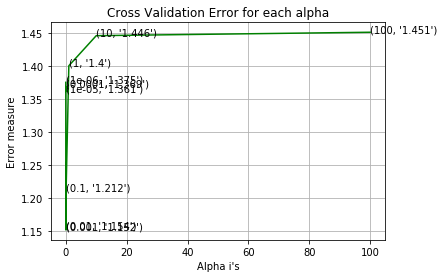

For values of best alpha =  0.001 The train log loss is: 0.5753039736624821
For values of best alpha =  0.001 The cross validation log loss is: 1.1522055558306348
For values of best alpha =  0.001 The test log loss is: 1.0575542740838857


In [35]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

predict_y = sig_clf.predict_proba(train_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

<h5>4.3.2.2. Testing model with best hyper parameters</h5>

Log loss : 1.1522055558306348
Number of mis-classified points : 0.37218045112781956
-------------------- Confusion matrix --------------------


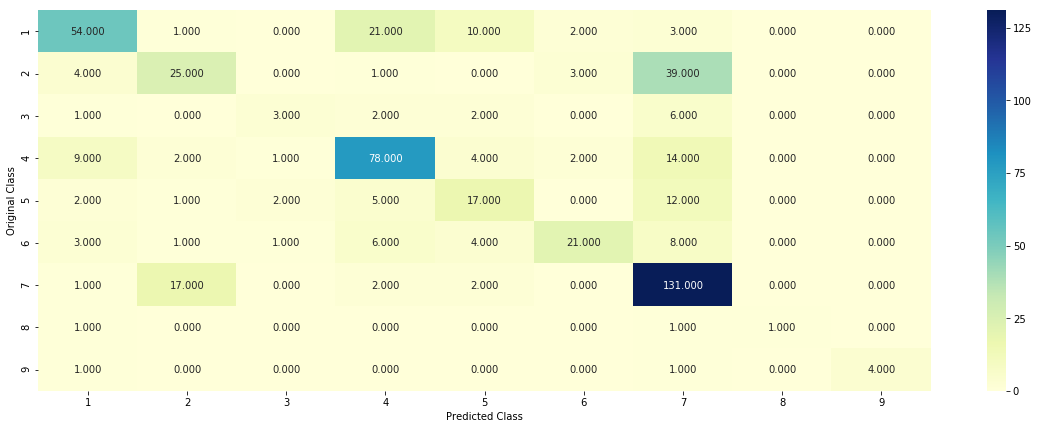

-------------------- Precision matrix (Columm Sum=1) --------------------


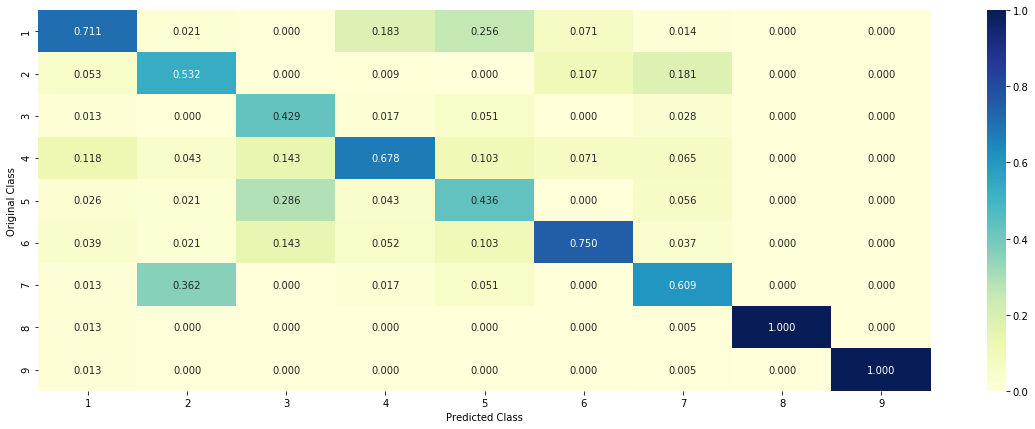

-------------------- Recall matrix (Row sum=1) --------------------


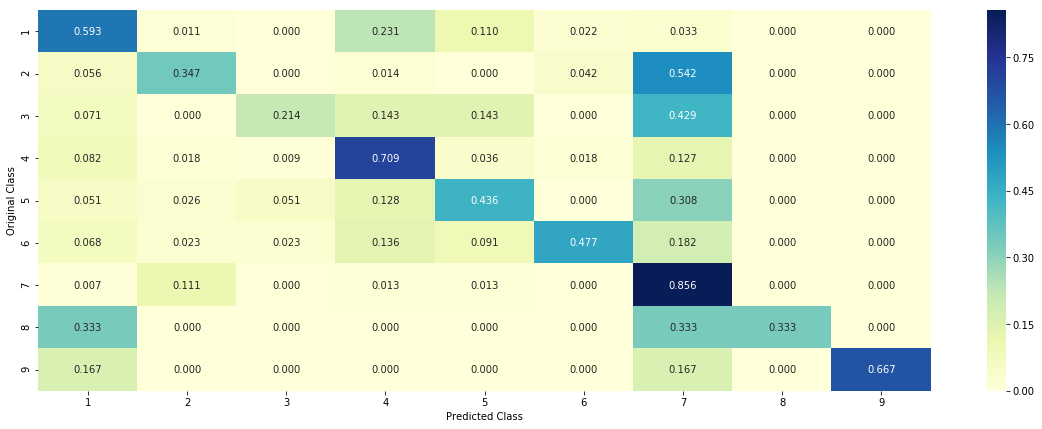

In [37]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_vec, train_y, cv_x_vec, cv_y, clf)

<h5>4.3.1.3.1. InCorrectly Classified point</h5>

In [38]:
# from tabulate import tabulate
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vec,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[9.421e-01 9.100e-03 7.000e-04 2.200e-02 5.400e-03 4.000e-03 1.570e-02
  1.000e-03 0.000e+00]]
Actual Class : 4
--------------------------------------------------
150 Text feature [ws] present in test data point [True]
159 Text feature [endonucleases] present in test data point [True]
196 Text feature [hpv] present in test data point [True]
298 Text feature [tsa] present in test data point [True]
390 Text feature [aggregation] present in test data point [True]
466 Text feature [assemble] present in test data point [True]
Out of the top  500  features  6 are present in query point


<h5>4.3.1.3.2. Correctly Classified point</h5>

In [39]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[6.500e-03 4.100e-03 3.000e-04 2.800e-03 6.210e-02 9.214e-01 2.200e-03
  6.000e-04 0.000e+00]]
Actual Class : 6
--------------------------------------------------
235 Text feature [910] present in test data point [True]
298 Text feature [v1804d] present in test data point [True]
375 Text feature [ivs13] present in test data point [True]
390 Text feature [951] present in test data point [True]
410 Text feature [fell] present in test data point [True]
Out of the top  500  features  5 are present in query point


<h2>4.4. Linear Support Vector Machines</h2>

<h3>4.4.1. Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.088511100848397
for C = 0.0001
Log Loss : 1.0531147661986384
for C = 0.001
Log Loss : 1.0459603988987558
for C = 0.01
Log Loss : 1.2365437985184977
for C = 0.1
Log Loss : 1.6150505534576975
for C = 1
Log Loss : 1.753358338993313
for C = 10
Log Loss : 1.7533584846512407
for C = 100
Log Loss : 1.7533585326745096


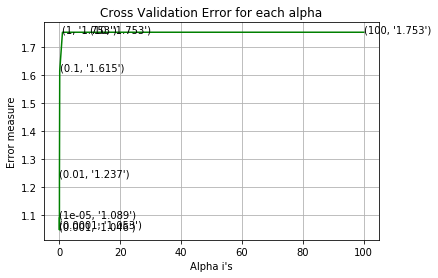

For values of best alpha =  0.001 The train log loss is: 0.6150160675056072
For values of best alpha =  0.001 The cross validation log loss is: 1.0459603988987558
For values of best alpha =  0.001 The test log loss is: 1.0819893826526379


In [79]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidfvector, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidfvector, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidfvector)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidfvector, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidfvector, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

<h3>4.4.2. Testing model with best hyper parameters</h3>

Log loss : 1.0459603988987558
Number of mis-classified points : 0.35150375939849626
-------------------- Confusion matrix --------------------


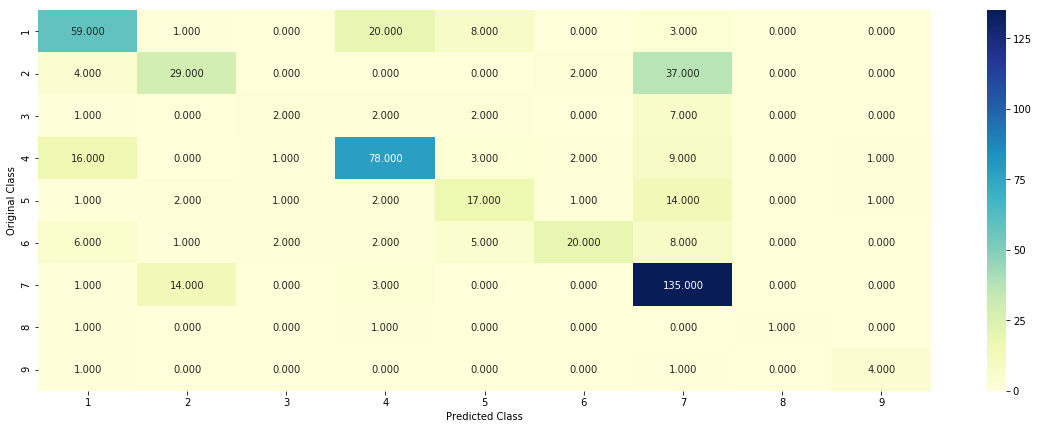

-------------------- Precision matrix (Columm Sum=1) --------------------


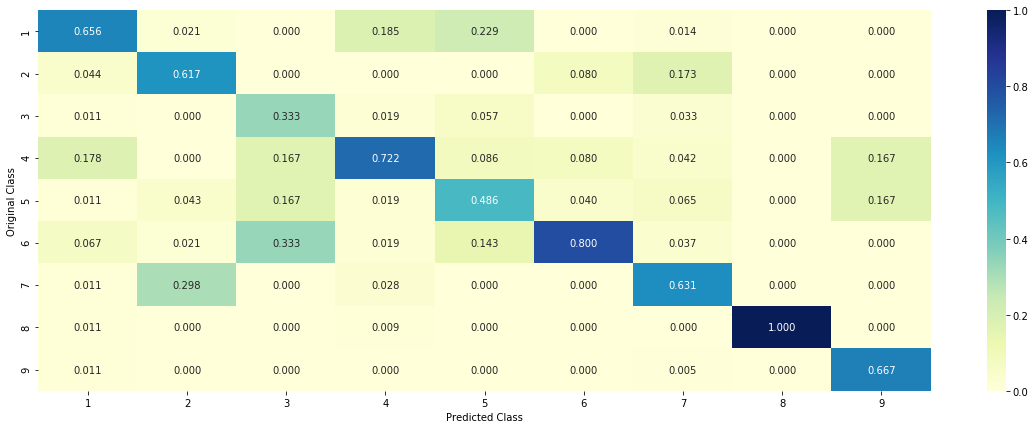

-------------------- Recall matrix (Row sum=1) --------------------


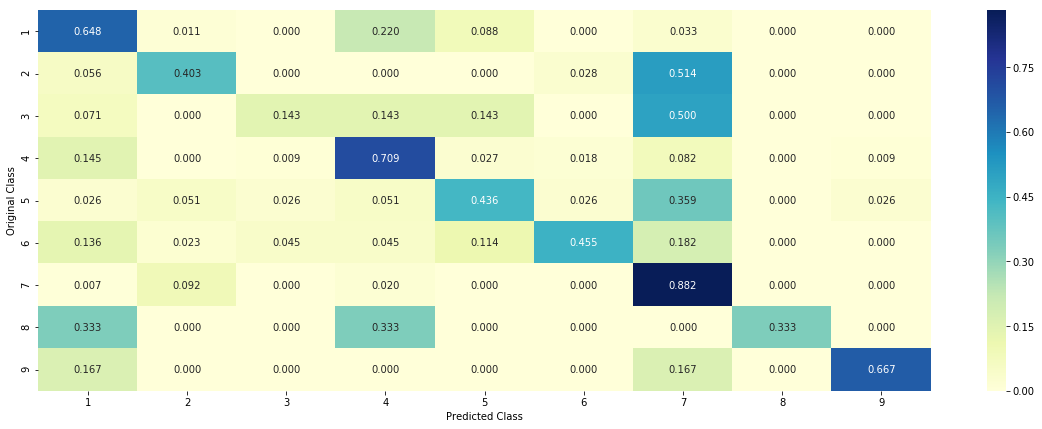

In [80]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_tfidfvector, train_y,cv_x_tfidfvector,cv_y, clf)

<h3>4.3.3. Feature Importance</h3>

<h5>4.3.3.1. For InCorrectly classified point</h5>

In [82]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidfvector,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_tfidfvector[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidfvector[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.637  0.0253 0.0098 0.2185 0.019  0.0198 0.0648 0.0026 0.0033]]
Actual Class : 4
--------------------------------------------------
15 Text feature [100] present in test data point [True]
314 Text feature [101] present in test data point [True]
323 Text feature [10] present in test data point [True]
Out of the top  500  features  3 are present in query point


<h5>4.3.3.2. For Correctly classified point</h5>

In [83]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_tfidfvector[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidfvector[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[2.780e-02 3.790e-02 3.600e-03 3.340e-02 5.980e-02 8.045e-01 3.130e-02
  1.100e-03 6.000e-04]]
Actual Class : 6
--------------------------------------------------
22 Text feature [114] present in test data point [True]
160 Text feature [1010] present in test data point [True]
161 Text feature [11delt] present in test data point [True]
164 Text feature [00] present in test data point [True]
165 Text feature [121] present in test data point [True]
198 Text feature [045] present in test data point [True]
222 Text feature [105] present in test data point [True]
272 Text feature [106] present in test data point [True]
273 Text feature [11] present in test data point [True]
278 Text feature [108] present in test data point [True]
320 Text feature [117] present in test data point [True]
347 Text feature [10g] present in test data point [True]
357 Text feature [11t] present in test data point [True]
385 Text feature [07] present in test data 

<h2>4.5 Random Forest Classifier</h2>

<h2>4.5.1. Hyper paramter tuning</h2>

In [88]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidfvector, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidfvector, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_tfidfvector)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_tfidfvector, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidfvector, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidfvector)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidfvector)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidfvector)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2033263097472144
for n_estimators = 100 and max depth =  10
Log Loss : 1.2500621643513115
for n_estimators = 200 and max depth =  5
Log Loss : 1.1848072334606536
for n_estimators = 200 and max depth =  10
Log Loss : 1.2352952167736817
for n_estimators = 500 and max depth =  5
Log Loss : 1.176210211676019
for n_estimators = 500 and max depth =  10
Log Loss : 1.2197535639815897
for n_estimators = 1000 and max depth =  5
Log Loss : 1.174669509293771
for n_estimators = 1000 and max depth =  10
Log Loss : 1.2186397059386738
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1734947016607695
for n_estimators = 2000 and max depth =  10
Log Loss : 1.2175314916651963
For values of best estimator =  2000 The train log loss is: 0.8472964664681095
For values of best estimator =  2000 The cross validation log loss is: 1.1734947016607695
For values of best estimator =  2000 The test log loss is: 1.1825991845399206


<h3>4.5.2. Testing model with best hyper parameters</h3>

Log loss : 1.1734947016607695
Number of mis-classified points : 0.3966165413533835
-------------------- Confusion matrix --------------------


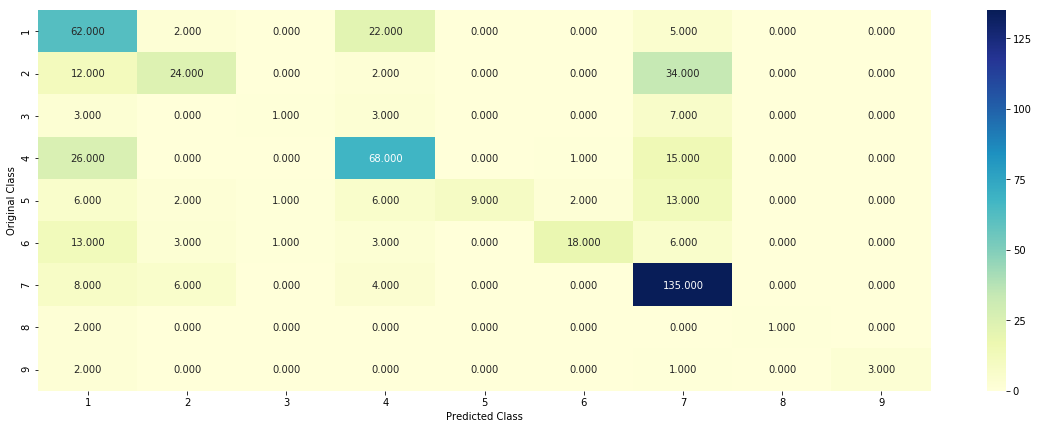

-------------------- Precision matrix (Columm Sum=1) --------------------


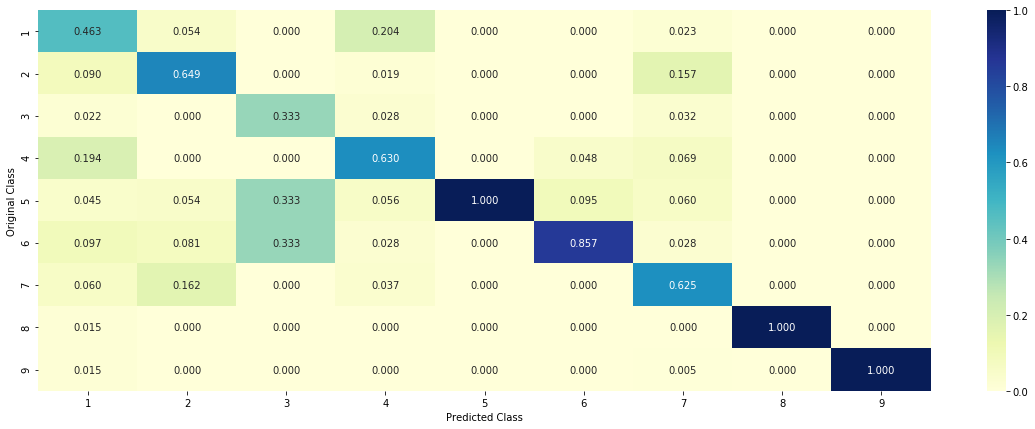

-------------------- Recall matrix (Row sum=1) --------------------


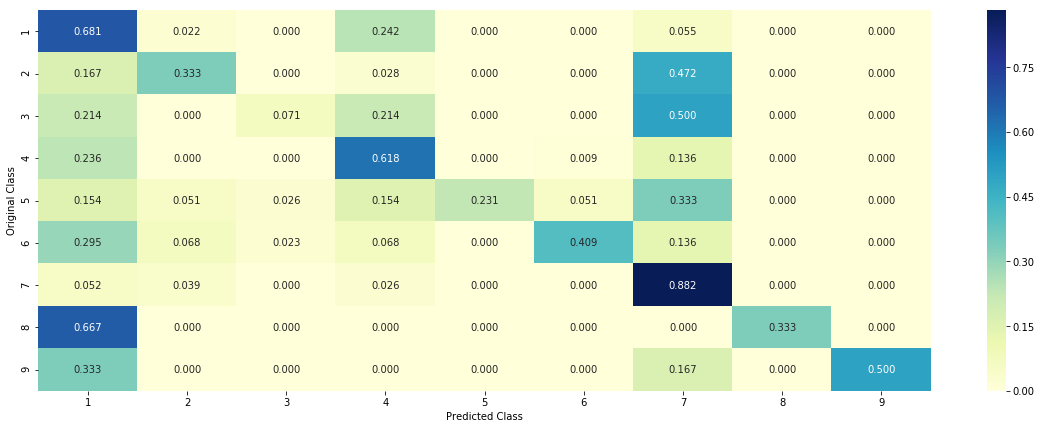

In [89]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_tfidfvector, train_y,cv_x_tfidfvector,cv_y, clf)

<h3>4.5.3. Feature Importance</h3>

<h4>4.5.3.1. InCorrectly Classified point</h4>

In [91]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_tfidfvector, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidfvector, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_tfidfvector[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidfvector[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.6012 0.0149 0.0083 0.2445 0.0394 0.0331 0.0417 0.0052 0.0117]]
Actual Class : 4
--------------------------------------------------
55 Text feature [002] present in test data point [True]
Out of the top  100  features  1 are present in query point


<h5>4.5.3.2. Correctly Classified point</h5>

In [92]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_tfidfvector[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidfvector[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[2.030e-02 3.800e-03 3.700e-03 1.260e-02 1.048e-01 8.440e-01 8.600e-03
  1.500e-03 7.000e-04]]
Actuall Class : 6
--------------------------------------------------
21 Text feature [111] present in test data point [True]
46 Text feature [066] present in test data point [True]
59 Text feature [114] present in test data point [True]
62 Text feature [05] present in test data point [True]
74 Text feature [046] present in test data point [True]
87 Text feature [045] present in test data point [True]
88 Text feature [123] present in test data point [True]
Out of the top  100  features  7 are present in query point


<h2>4.7 Stack the models</h2>

<h3>4.7.1 testing with hyper parameter tuning</h3>

In [95]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_tfidfvector, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_tfidfvector, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_tfidfvector, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_tfidfvector, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_tfidfvector))))
sig_clf2.fit(train_x_tfidfvector, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_tfidfvector))))
sig_clf3.fit(train_x_tfidfvector, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_tfidfvector))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_tfidfvector, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_tfidfvector))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_tfidfvector))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 0.98
Support vector machines : Log Loss: 1.75
Naive Bayes : Log Loss: 1.15
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.177
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.028
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.481
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.114
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.281
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.690


<h3>4.7.2 testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.537670528847927
Log loss (CV) on the stacking classifier : 1.1144712972012176
Log loss (test) on the stacking classifier : 1.2024426598531286
Number of missclassified point : 0.3849624060150376
-------------------- Confusion matrix --------------------


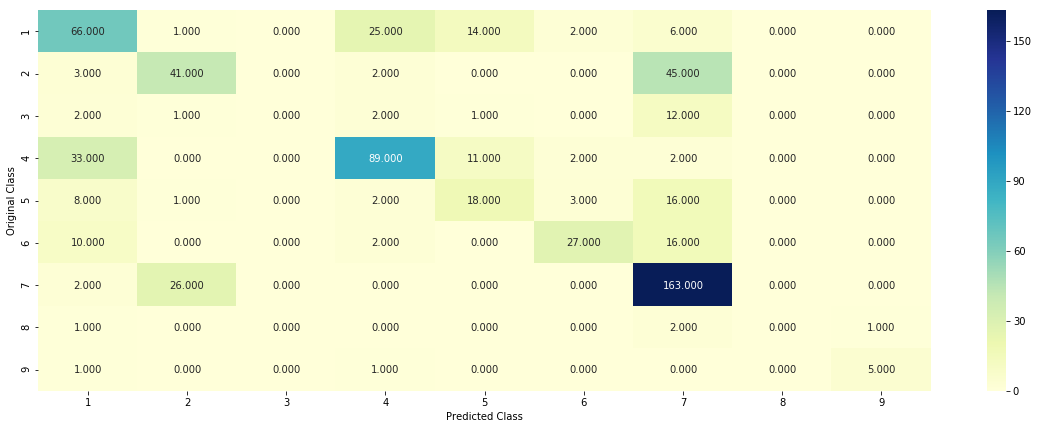

-------------------- Precision matrix (Columm Sum=1) --------------------


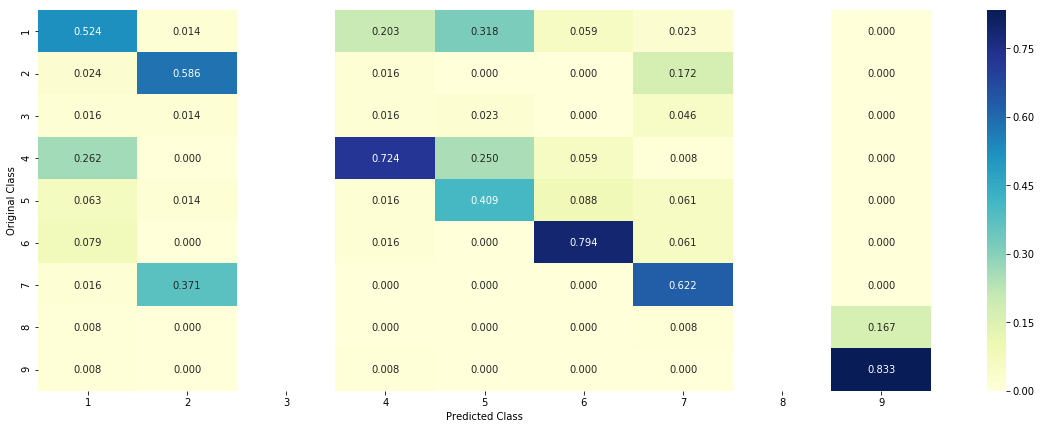

-------------------- Recall matrix (Row sum=1) --------------------


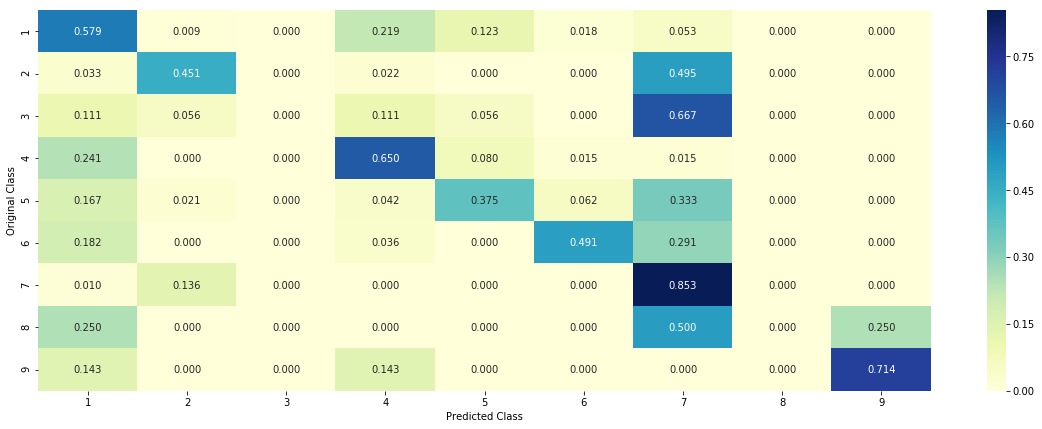

In [96]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_tfidfvector, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_tfidfvector))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_tfidfvector))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_tfidfvector))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_tfidfvector)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_tfidfvector))

<h3>4.7.3 Maximum Voting classifier</h3>

Log loss (train) on the VotingClassifier : 0.832065081317097
Log loss (CV) on the VotingClassifier : 1.1587377502513951
Log loss (test) on the VotingClassifier : 1.2039784707560393
Number of missclassified point : 0.37894736842105264
-------------------- Confusion matrix --------------------


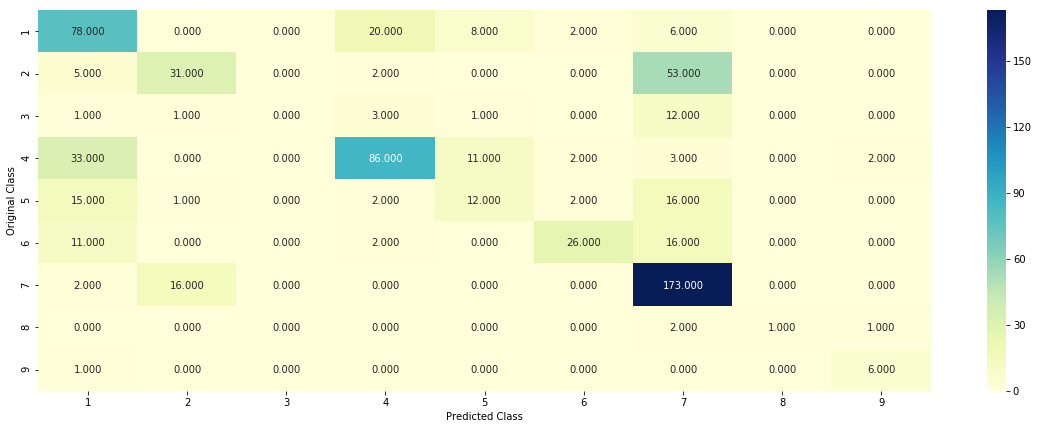

-------------------- Precision matrix (Columm Sum=1) --------------------


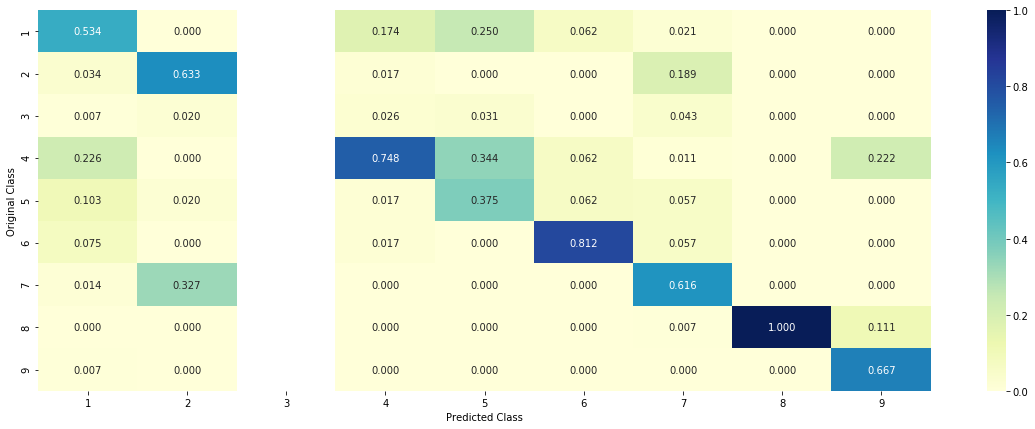

-------------------- Recall matrix (Row sum=1) --------------------


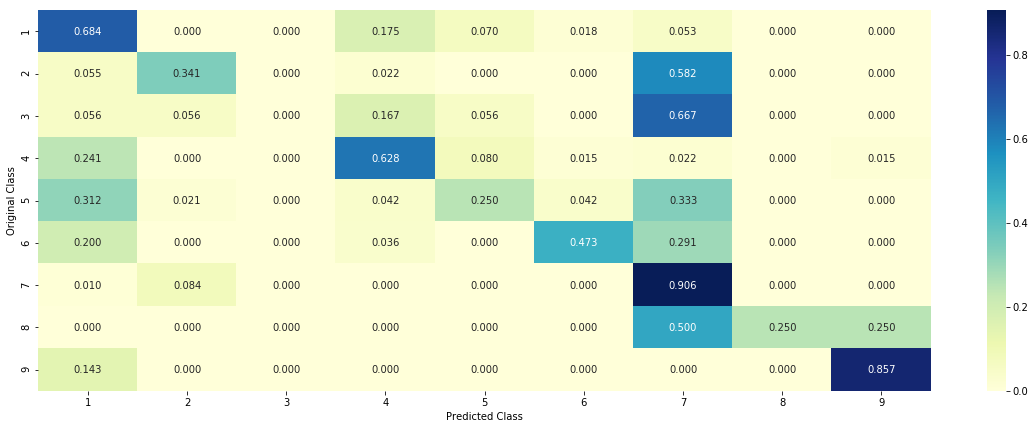

In [97]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_tfidfvector, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_tfidfvector)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_tfidfvector)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_tfidfvector)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_tfidfvector)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_tfidfvector))

<h1>3) Apply Logistic regression with CountVectorizer Features, including both unigrams and bigrams¶</h1>

<h3>Count Vectorization of data</h3>

In [3]:
# Count Vectorization of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_countvector = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_countvector = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_countvector = gene_vectorizer.transform(cv_df['Gene'])

In [4]:
# Count Vectorization of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_countvector = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_countvector = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_countvector = variation_vectorizer.transform(cv_df['Variation'])

In [5]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3, ngram_range =(1,2))
train_text_feature_countvector = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_countvector.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 800981


In [6]:
# don't forget to normalize every feature
train_text_feature_countvector = normalize(train_text_feature_countvector, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_countvector = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_countvector = normalize(test_text_feature_countvector, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_countvector = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_countvector = normalize(cv_text_feature_countvector, axis=0)

<h3>Stacking three types of features</h3>

In [7]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_countvector = hstack((train_gene_feature_countvector,train_variation_feature_countvector))
test_gene_var_countvector = hstack((test_gene_feature_countvector, test_variation_feature_countvector))
cv_gene_var_countvector = hstack((cv_gene_feature_countvector,cv_variation_feature_countvector))

train_x_countvector = hstack((train_gene_var_countvector, train_text_feature_countvector)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_countvector = hstack((test_gene_var_countvector, test_text_feature_countvector)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_countvector = hstack((cv_gene_var_countvector, cv_text_feature_countvector)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [8]:
print("Count Data features :")
print("(number of data points * number of features) in train data = ", train_x_countvector.shape)
print("(number of data points * number of features) in test data = ", test_x_countvector.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_countvector.shape)

Count Data features :
(number of data points * number of features) in train data =  (2124, 803159)
(number of data points * number of features) in test data =  (665, 803159)
(number of data points * number of features) in cross validation data = (532, 803159)


In [9]:
train_x_vec = train_x_countvector
cv_x_vec = cv_x_countvector
test_x_vec = test_x_countvector

In [10]:
print(train_x_vec.shape)
print(cv_x_vec.shape)
print(test_x_vec.shape)

(2124, 803159)
(532, 803159)
(665, 803159)


<h3>4.3. Logistic Regression</h3>

<h4>4.3.1. With Class balancing </h4>

<h5>4.3.1.1. Hyper paramter tuning</h5>

for alpha = 1e-06
Log Loss : 1.6119268533851585
for alpha = 1e-05
Log Loss : 1.6088552903487265
for alpha = 0.0001
Log Loss : 1.6349359140753943
for alpha = 0.001
Log Loss : 1.5623702602752267
for alpha = 0.01
Log Loss : 1.2493401048728523
for alpha = 0.1
Log Loss : 1.1965548388843998
for alpha = 1
Log Loss : 1.2640188716621523
for alpha = 10
Log Loss : 1.3573810249059362
for alpha = 100
Log Loss : 1.3778171614879662


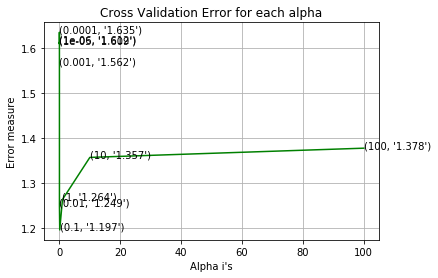

For values of best alpha =  0.1 The train log loss is: 0.8386798771214776
For values of best alpha =  0.1 The cross validation log loss is: 1.1965548388843998
For values of best alpha =  0.1 The test log loss is: 1.178669652311356


In [11]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

predict_y = sig_clf.predict_proba(train_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

<h5>4.3.1.2. Testing the model with best hyper paramters</h5>

Log loss : 1.1965548388843998
Number of mis-classified points : 0.4191729323308271
-------------------- Confusion matrix --------------------


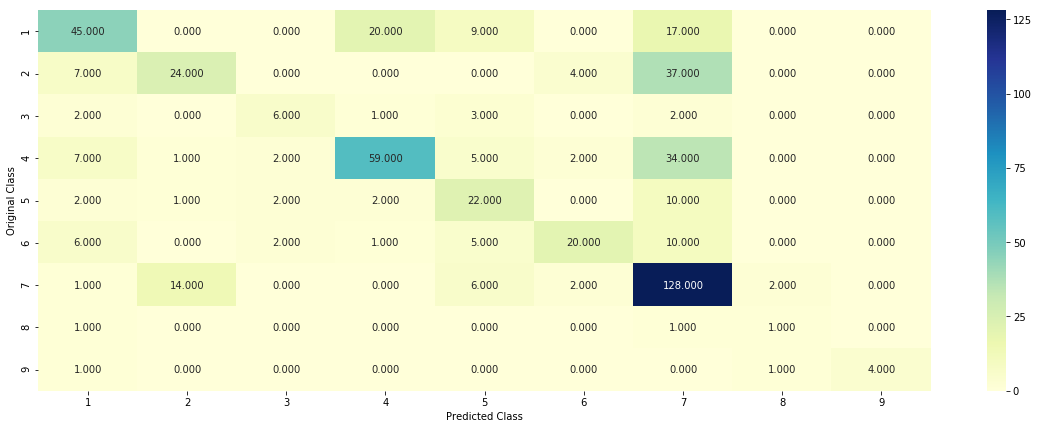

-------------------- Precision matrix (Columm Sum=1) --------------------


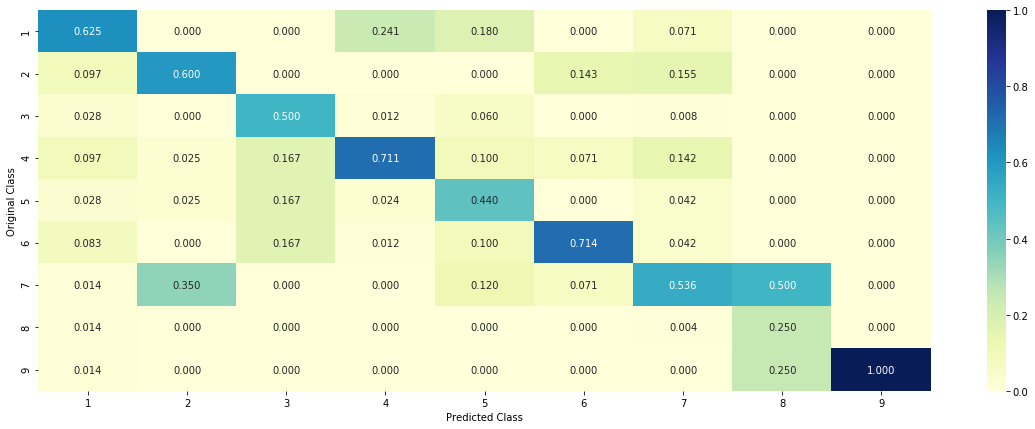

-------------------- Recall matrix (Row sum=1) --------------------


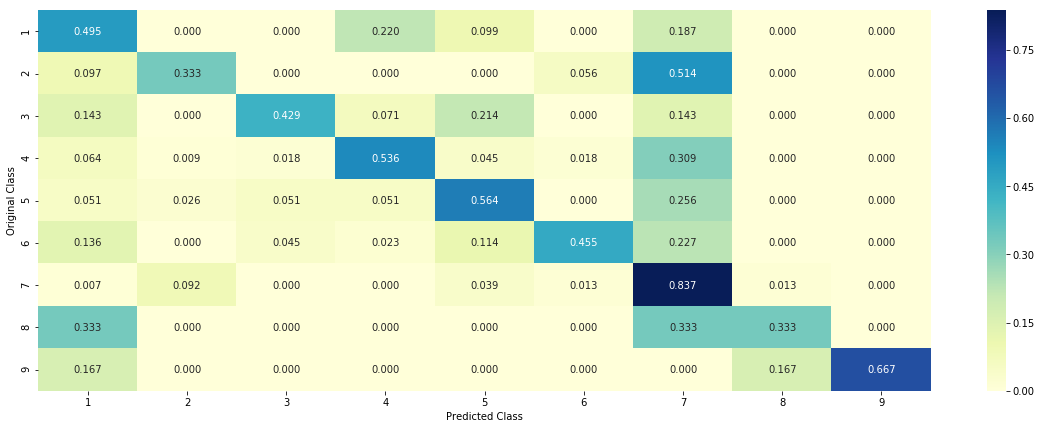

In [17]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_vec, train_y, cv_x_vec, cv_y, clf)

<h5>4.3.1.3. Feature Importance</h5>

In [26]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_countvector.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h5>4.3.1.3.1. InCorrectly Classified point</h5>

In [38]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3, ngram_range =(1,2))
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [39]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vec,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[9.813e-01 3.700e-03 4.000e-04 7.400e-03 1.500e-03 6.000e-04 3.400e-03
  1.400e-03 3.000e-04]]
Actual Class : 4
--------------------------------------------------
228 Text feature [controller] present in test data point [True]
Out of the top  500  features  1 are present in query point


<h5>4.3.1.3.2. Correctly Classified point</h5>

In [40]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[1.310e-02 6.000e-03 8.000e-04 5.900e-03 2.480e-02 9.437e-01 3.600e-03
  1.600e-03 5.000e-04]]
Actual Class : 6
--------------------------------------------------
155 Text feature [ivs13] present in test data point [True]
395 Text feature [m1652t] present in test data point [True]
442 Text feature [i2285v] present in test data point [True]
Out of the top  500  features  3 are present in query point


<h3>4.3.2. Without Class balancing</h3>

<h4>4.3.2.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.5212560973271876
for alpha = 1e-05
Log Loss : 1.5457801039670809
for alpha = 0.0001
Log Loss : 1.5475180850232522
for alpha = 0.001
Log Loss : 1.5034539090576275
for alpha = 0.01
Log Loss : 1.2728428123829316
for alpha = 0.1
Log Loss : 1.212649188580778
for alpha = 1
Log Loss : 1.2951917392454833


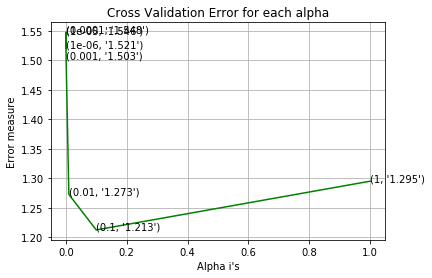

For values of best alpha =  0.1 The train log loss is: 0.829160772396843
For values of best alpha =  0.1 The cross validation log loss is: 1.212649188580778
For values of best alpha =  0.1 The test log loss is: 1.1895465873179003


In [42]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

predict_y = sig_clf.predict_proba(train_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.3.2.2. Testing model with best hyper parameters</h4>

Log loss : 1.212649188580778
Number of mis-classified points : 0.39849624060150374
-------------------- Confusion matrix --------------------


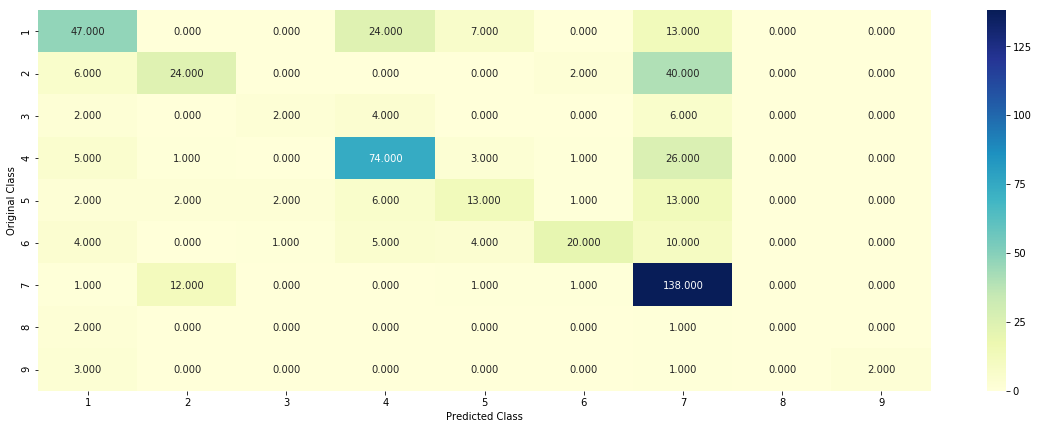

-------------------- Precision matrix (Columm Sum=1) --------------------


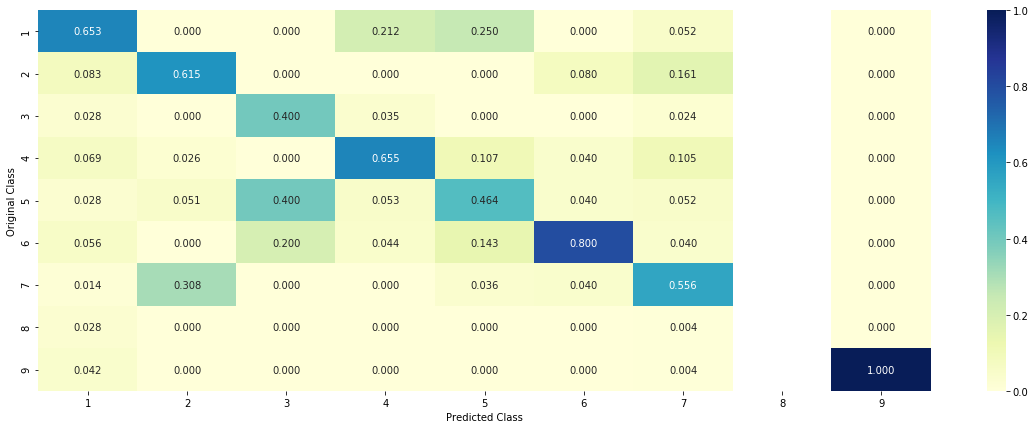

-------------------- Recall matrix (Row sum=1) --------------------


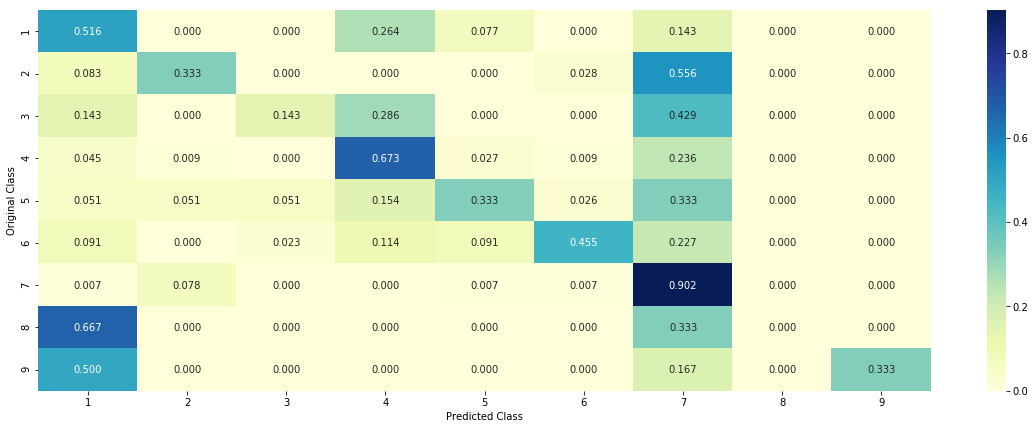

In [43]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_vec, train_y, cv_x_vec, cv_y, clf)

<h5>4.3.2.3. Feature Importance, Correctly Classified point</h5>

In [44]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vec,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[9.83e-01 3.10e-03 6.00e-04 6.10e-03 1.60e-03 3.00e-04 2.80e-03 2.50e-03
  0.00e+00]]
Actual Class : 4
--------------------------------------------------
489 Text feature [controller] present in test data point [True]
Out of the top  500  features  1 are present in query point


<h6>4.3.2.4. Feature Importance, Inorrectly Classified point</h6>

In [45]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[1.230e-02 6.100e-03 1.300e-03 4.300e-03 1.940e-02 9.508e-01 2.600e-03
  3.000e-03 1.000e-04]]
Actual Class : 6
--------------------------------------------------
128 Text feature [ivs13] present in test data point [True]
Out of the top  500  features  1 are present in query point


<h2>Try any of the feature engineering techniques discussed in the course to reduce the CV and test log-loss to a value less than 1.0</h2>

<h2>NEWLY ENGINEERED FEATURE 1 : MAX_FREQUENT_WORD_CLASS </h2>

In [ ]:
###################################################################################################
The new feature max_frequent_word_class is a categorical feature.It contains one among the 9 classes to be predicted
as the output.Each data point is assigned a class to the maximum frequent words present in the text feature of the point

Detailed procedure of how the feature is built:
    
PROPROCESSING:
---------------

1)In training data, collect all the words in the text feature with high tf-idf value.Here,I have collected all the 
words with tf-idf greater than 0.03

2)Then for each class, collect that top 10 words in that class which has the maximum tf-idf values ie,)that
belongs to the list of words collected above

At the end of the step 2, we would be left with a 9 length list of dictionary where each dictionary has maximum 
frequent words in that particular class

FEATURE CONSTRUCTION:
----------------------

for a given data point to assign its corresponding max_frequent_word_class value follow the steps below:
    
1)construct a dictionary of words in the text feature of the data point.The key is the words in the text and value
is the frequency of the occurence of the word in the text

2)For each 9 classes to be predicted, we need to find a score.

3)Assign the class with the maximum score as the max_frequent_word_class of the data point

FINDING SCORE OF A CLASS:
-------------------------
1)Intially score = 0

2)Get the dict having from the top 10 frequent word of that class from the list constructed on the preprocessing 
step.Let it be called class_frequent_word_dict

3)for each in the class_frequent_word_dict,do the following:
    
2)find whether the word is present in the text of the data point(already constructed a dict of words in the first
step in the feature construction) 

3)if it is then score = score + w*frequency of the word in the data point.Here, w is the weight for that
word.Top frequent word of the class has weight 10, next frequent word has weight 9 and so on.10 top frequent words
of each class has weights 10 to 1 in the increasing order of their frequency.

In [3]:
# TF-IDF Vectorization of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_tfidfvector = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_tfidfvector = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_tfidfvector = gene_vectorizer.transform(cv_df['Gene'])

In [4]:
# TF-IDF Vectorization of variation feature.
variation_vectorizer = TfidfVectorizer()
train_variation_feature_tfidfvector = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_tfidfvector = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_tfidfvector = variation_vectorizer.transform(cv_df['Variation'])

In [5]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_tfidfvector = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_tfidfvector.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 54235


In [6]:
# don't forget to normalize every feature
train_text_feature_tfidfvector = normalize(train_text_feature_tfidfvector, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_tfidfvector = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_tfidfvector = normalize(test_text_feature_tfidfvector, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_tfidfvector = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_tfidfvector = normalize(cv_text_feature_tfidfvector, axis=0)

In [7]:
train_gene_var_tfidfvector = hstack((train_gene_feature_tfidfvector,train_variation_feature_tfidfvector))
test_gene_var_tfidfvector = hstack((test_gene_feature_tfidfvector, test_variation_feature_tfidfvector))
cv_gene_var_tfidfvector = hstack((cv_gene_feature_tfidfvector,cv_variation_feature_tfidfvector))

train_x_tfidfvector = hstack((train_gene_var_tfidfvector, train_text_feature_tfidfvector)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_tfidfvector = hstack((test_gene_var_tfidfvector, test_text_feature_tfidfvector)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_tfidfvector = hstack((cv_gene_var_tfidfvector, cv_text_feature_tfidfvector)).tocsr()
cv_y = np.array(list(cv_df['Class']))

<h3>Feature construction</h3>

In [8]:
#Constructing a dictionary with all the words:corresponsing tf-idf value from the text feature in train data
words_tfidf_dict = {}
feature_names = text_vectorizer.get_feature_names()
doc = 0
feature_index = train_text_feature_tfidfvector[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [train_text_feature_tfidfvector[doc, x] for x in feature_index])
for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    words_tfidf_dict[w] =s

In [9]:
#Sorting the dictionary constructed above with tf-idf value(key)
import operator
words_tfidf_dict = dict( sorted(words_tfidf_dict.items(), key=operator.itemgetter(1),reverse=True))

In [10]:
words_tfidf_dict

{'1366': 0.17419719067923367,
 'm1628t': 0.1726220992660933,
 'g1788v': 0.17233328255323008,
 't1720a': 0.16921864838070502,
 'l1407p': 0.16784301746876829,
 'g1706a': 0.16734676777272364,
 'w1837r': 0.16407076027357514,
 'm1628v': 0.1622536251519139,
 'a1752p': 0.1615191880568471,
 'h1421y': 0.15859457582044278,
 '11b24': 0.15859457582044276,
 '11number': 0.15859457582044276,
 '1interspecific': 0.15859457582044276,
 '59agaaggctggctcccatactgttctaac': 0.15859457582044276,
 '59atagtcgacttccagccca': 0.15859457582044276,
 '59cggaatt': 0.15859457582044276,
 '59cggaattcacttcacagaaaagtagt': 0.15859457582044276,
 '59cggaattccagagggataccatgcaa': 0.15859457582044276,
 '59cggaattcgg': 0.15859457582044276,
 '59gc': 0.15859457582044276,
 '59gcggaattcatgg': 0.15859457582044276,
 '59gcggtcga': 0.15859457582044276,
 'a1752pf': 0.15859457582044276,
 'a4956g': 0.15859457582044276,
 'a5001g': 0.15859457582044276,
 'a5277g': 0.15859457582044276,
 'a752pr': 0.15859457582044276,
 'aaagtgtgagcagg': 0.1585945

In [11]:
#Obtaining words with the tf-idf value greater than 0.03
top_tfidf_words_dict = {}
for each in words_tfidf_dict:
    if words_tfidf_dict[each] > 0.03:
        top_tfidf_words_dict[each] = words_tfidf_dict[each]
    else:
        break

In [12]:
len(top_tfidf_words_dict)

1550

In [13]:
top_tfidf_words_dict

{'1366': 0.17419719067923367,
 'm1628t': 0.1726220992660933,
 'g1788v': 0.17233328255323008,
 't1720a': 0.16921864838070502,
 'l1407p': 0.16784301746876829,
 'g1706a': 0.16734676777272364,
 'w1837r': 0.16407076027357514,
 'm1628v': 0.1622536251519139,
 'a1752p': 0.1615191880568471,
 'h1421y': 0.15859457582044278,
 '11b24': 0.15859457582044276,
 '11number': 0.15859457582044276,
 '1interspecific': 0.15859457582044276,
 '59agaaggctggctcccatactgttctaac': 0.15859457582044276,
 '59atagtcgacttccagccca': 0.15859457582044276,
 '59cggaatt': 0.15859457582044276,
 '59cggaattcacttcacagaaaagtagt': 0.15859457582044276,
 '59cggaattccagagggataccatgcaa': 0.15859457582044276,
 '59cggaattcgg': 0.15859457582044276,
 '59gc': 0.15859457582044276,
 '59gcggaattcatgg': 0.15859457582044276,
 '59gcggtcga': 0.15859457582044276,
 'a1752pf': 0.15859457582044276,
 'a4956g': 0.15859457582044276,
 'a5001g': 0.15859457582044276,
 'a5277g': 0.15859457582044276,
 'a752pr': 0.15859457582044276,
 'aaagtgtgagcagg': 0.1585945

In [14]:
#Preprocessing stage - constructing top 10 frequent words for each of the class
frequent_words_in_class_dict = []   #list of 9 dicts each dict contains the maximum frequent 10 words of each class in the text

def construct_frequent_words_of_each_class():
    for i in list(range(1,10)):
        class_text = train_df[train_df['Class']==i]['TEXT'].values
        words_in_class = []
        for each in class_text:
            words_in_class = words_in_class + each.split()
        frequent_words_dict = {}
        for each in words_in_class:
            if each.lower() not in frequent_words_dict:
                frequent_words_dict[each.lower()] = 1
            else:
                frequent_words_dict[each.lower()] = frequent_words_dict[each.lower()] + 1
        class_word_tfidf_dict = {}
        for each in words_in_class:
            if each in top_tfidf_words_dict:
                class_word_tfidf_dict[each] = top_tfidf_words_dict[each]
        class_word_tfidf_dict = dict( sorted(class_word_tfidf_dict.items(), key=operator.itemgetter(1),reverse=True))
        top_10_frequent_dict = {}
        i = 10
        for each in frequent_words_dict:
            if each in words_tfidf_dict:
                top_10_frequent_dict[each] = words_tfidf_dict[each]
                i = i-1
                if i==0:
                    break
        frequent_words_in_class_dict.append(top_10_frequent_dict) 

In [15]:
construct_frequent_words_of_each_class()

In [16]:
frequent_words_in_class_dict

[{'abstract': 0.026011147072247415,
  'characterization': 0.03742622451140856,
  'novel': 0.002281173922118846,
  'null': 0.02567452844522359,
  'allele': 0.020232400930762257,
  '15': 0.02472643597763063,
  'seven': 0.054641718868164775,
  'base': 0.0032433719460866458,
  'pair': 0.011219068245821954,
  'deletion': 0.010546130902501241},
 {'activating': 0.005531349297476084,
  'mutations': 0.022364127252933946,
  'present': 0.034484574704088826,
  '50': 0.030851963303135152,
  'human': 0.048486351706710756,
  'cell': 0.005480203693562856,
  'samples': 0.006339748321622149,
  'inhibition': 0.007994331410191626,
  'signaling': 0.002474161232527802,
  'inhibitors': 0.0010762820537768504},
 {'unique': 0.003859750166326755,
  'mammals': 0.03146519106772842,
  'terms': 0.03310501774368408,
  'tumor': 0.007523724562666595,
  'suppressor': 0.00537108623440981,
  'activity': 0.027749521705878192,
  'second': 0.010739766815781775,
  'activates': 0.009213200111345254,
  'kinase': 0.0008214483496

In [17]:
#Function which assigns max_frequent_word_class value for each data point based on the class scores
def get_max_frequent_words_class(text):
    class_scores = []
    text = text.split()
    frequent_words_dict = {}
    for each in text:
        if each.lower() not in frequent_words_dict:
            frequent_words_dict[each.lower()] = 1
        else:
            frequent_words_dict[each.lower()] = frequent_words_dict[each.lower()] + 1
    frequent_words_dict = dict( sorted(frequent_words_dict.items(), key=operator.itemgetter(0),reverse=True))
    for i in range(0,9):
        class_i_frequent_words = frequent_words_in_class_dict[i]
        class_i_score = 0
        w = 10
        total_freq = 0
        for each in class_i_frequent_words:
            if each in  frequent_words_dict:
                class_i_score = class_i_score + w*frequent_words_dict[each]
                total_freq  = total_freq + frequent_words_dict[each]
            w = w-1    
        if total_freq != 0:
            class_i_scores = class_i_score/total_freq
        class_scores.append(class_i_score)
    return class_scores.index(max(class_scores)) + 1

In [18]:
#Creating the new feature values for train,test and cross validation data
max_frequent_word_class_cv = []
max_frequent_word_class_train = []
max_frequent_word_class_test = []
for index, each in cv_df.iterrows():
    max_frequent_word_class_cv.append(get_max_frequent_words_class(each['TEXT']))
for index, each in train_df.iterrows():
    max_frequent_word_class_train.append(get_max_frequent_words_class(each['TEXT']))
for index, each in test_df.iterrows():
    max_frequent_word_class_test.append(get_max_frequent_words_class(each['TEXT']))

In [19]:
#Appending the new feature created to train, test and cv data
max_frequent_word_class_cv = pd.DataFrame(max_frequent_word_class_cv)
max_frequent_word_class_cv.columns = ['max_frequent_word_class']
max_frequent_word_class_cv.index = cv_df.index
max_frequent_word_class_cv['ID'] = cv_df['ID']
cv_df = cv_df.merge(max_frequent_word_class_cv, on='ID',how='left')


max_frequent_word_class_train = pd.DataFrame(max_frequent_word_class_train, columns=['max_frequent_word_class'])
max_frequent_word_class_train.index = train_df.index
max_frequent_word_class_train['ID'] = train_df['ID']
train_df = train_df.merge(max_frequent_word_class_train, on='ID',how='left')


max_frequent_word_class_test = pd.DataFrame(max_frequent_word_class_test, columns=['max_frequent_word_class'])
max_frequent_word_class_test.index = test_df.index
max_frequent_word_class_test['ID'] = test_df['ID']
test_df = test_df.merge(max_frequent_word_class_test, on='ID',how='left')

In [20]:
train_df.head(5)

,ID,Gene,Variation,Class,TEXT,max_frequent_word_class
0,2630,BRCA1,T1720A,5,abstract germline mutations inactivate tumor s...,6
1,3224,NTRK1,CD74-NTRK1_Fusion,7,identified novel gene fusions patients lung ca...,7
2,870,HLA-B,Truncating_Mutations,1,abstract characterization novel hla b null all...,1
3,750,ERBB2,T798I,8,purpose mutations associated resistance kinase...,8
4,1713,POLE,F367S,4,abstract genomic sequences encoding 3 exonucle...,2


<h3> EDA of the max_frequent_word_class feature </h3>

In [21]:
#To view the distribution of max_frequent_word_class feature in each of the class in train data
class1_max_features_class_distribution = train_df[train_df['Class']==1]['max_frequent_word_class'].value_counts().sortlevel()
class2_max_features_class_distribution = train_df[train_df['Class']==2]['max_frequent_word_class'].value_counts().sortlevel()
class3_max_features_class_distribution = train_df[train_df['Class']==3]['max_frequent_word_class'].value_counts().sortlevel()
class4_max_features_class_distribution = train_df[train_df['Class']==4]['max_frequent_word_class'].value_counts().sortlevel()
class5_max_features_class_distribution = train_df[train_df['Class']==5]['max_frequent_word_class'].value_counts().sortlevel()
class6_max_features_class_distribution = train_df[train_df['Class']==6]['max_frequent_word_class'].value_counts().sortlevel()
class7_max_features_class_distribution = train_df[train_df['Class']==7]['max_frequent_word_class'].value_counts().sortlevel()
class8_max_features_class_distribution = train_df[train_df['Class']==8]['max_frequent_word_class'].value_counts().sortlevel()
class9_max_features_class_distribution = train_df[train_df['Class']==9]['max_frequent_word_class'].value_counts().sortlevel()

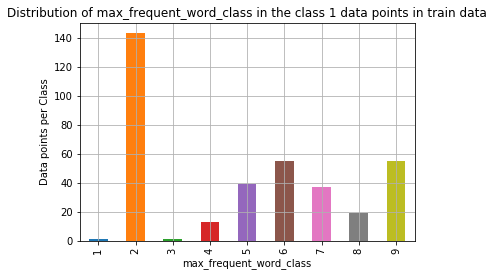

In [22]:
#Distribution of max_frequent_word_class in the class 1 data points in train data
my_colors = 'rgbkymc'
class1_max_features_class_distribution.plot(kind='bar')
plt.xlabel('max_frequent_word_class')
plt.ylabel('Data points per Class')
plt.title('Distribution of max_frequent_word_class in the class 1 data points in train data')
plt.grid()
plt.show()

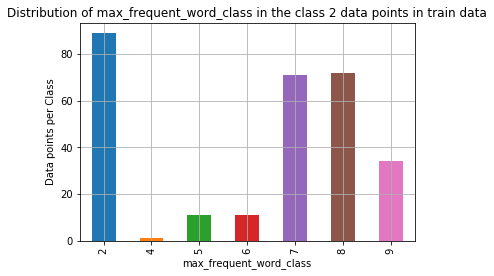

In [23]:
#Distribution of max_frequent_word_class in the class 2 data points in train data
my_colors = 'rgbkymc'
class2_max_features_class_distribution.plot(kind='bar')
plt.xlabel('max_frequent_word_class')
plt.ylabel('Data points per Class')
plt.title('Distribution of max_frequent_word_class in the class 2 data points in train data')
plt.grid()
plt.show()

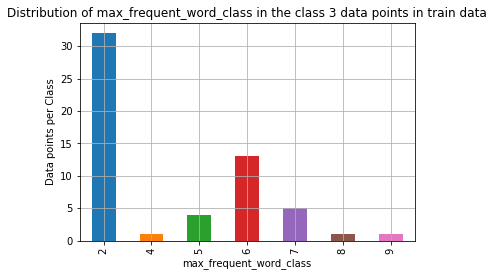

In [24]:
#Distribution of max_frequent_word_class in the class 3 data points in train data
my_colors = 'rgbkymc'
class3_max_features_class_distribution.plot(kind='bar')
plt.xlabel('max_frequent_word_class')
plt.ylabel('Data points per Class')
plt.title('Distribution of max_frequent_word_class in the class 3 data points in train data')
plt.grid()
plt.show()

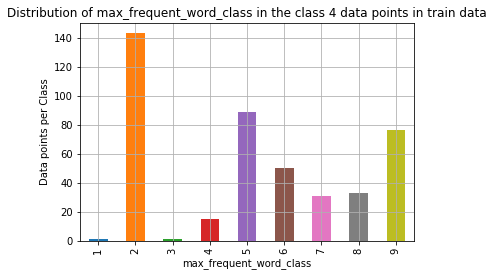

In [25]:
#Distribution of max_frequent_word_class in the class 4 data points in train data
my_colors = 'rgbkymc'
class4_max_features_class_distribution.plot(kind='bar')
plt.xlabel('max_frequent_word_class')
plt.ylabel('Data points per Class')
plt.title('Distribution of max_frequent_word_class in the class 4 data points in train data')
plt.grid()
plt.show()

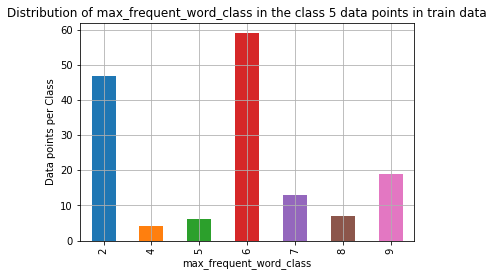

In [26]:
#Distribution of max_frequent_word_class in the class 5 data points in train data
my_colors = 'rgbkymc'
class5_max_features_class_distribution.plot(kind='bar')
plt.xlabel('max_frequent_word_class')
plt.ylabel('Data points per Class')
plt.title('Distribution of max_frequent_word_class in the class 5 data points in train data')
plt.grid()
plt.show()

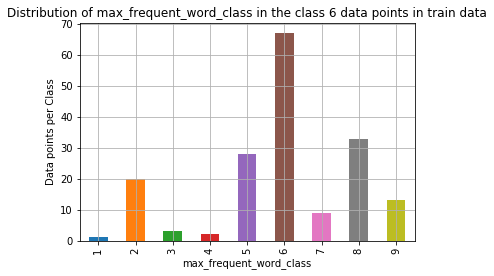

In [27]:
#Distribution of max_frequent_word_class in the class 6 data points in train data
my_colors = 'rgbkymc'
class6_max_features_class_distribution.plot(kind='bar')
plt.xlabel('max_frequent_word_class')
plt.ylabel('Data points per Class')
plt.title('Distribution of max_frequent_word_class in the class 6 data points in train data')
plt.grid()
plt.show()

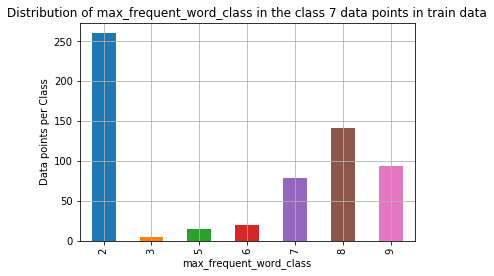

In [28]:
#Distribution of max_frequent_word_class in the class 7 data points in train data
my_colors = 'rgbkymc'
class7_max_features_class_distribution.plot(kind='bar')
plt.xlabel('max_frequent_word_class')
plt.ylabel('Data points per Class')
plt.title('Distribution of max_frequent_word_class in the class 7 data points in train data')
plt.grid()
plt.show()

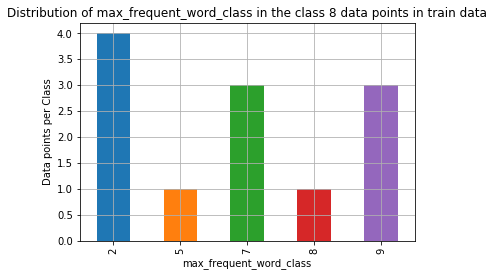

In [29]:
#Distribution of max_frequent_word_class in the class 8 data points in train data
my_colors = 'rgbkymc'
class8_max_features_class_distribution.plot(kind='bar')
plt.xlabel('max_frequent_word_class')
plt.ylabel('Data points per Class')
plt.title('Distribution of max_frequent_word_class in the class 8 data points in train data')
plt.grid()
plt.show()

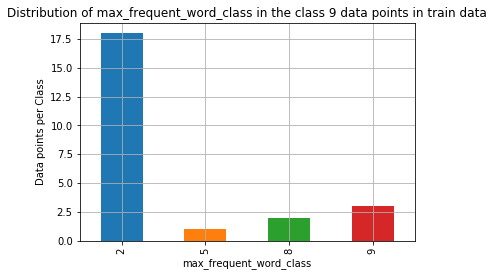

In [30]:
#Distribution of max_frequent_word_class in the class 9 data points in train data
my_colors = 'rgbkymc'
class9_max_features_class_distribution.plot(kind='bar')
plt.xlabel('max_frequent_word_class')
plt.ylabel('Data points per Class')
plt.title('Distribution of max_frequent_word_class in the class 9 data points in train data')
plt.grid()
plt.show()

<h6>Final Observation:</h6>
<p>
1)As observed from the above plot, max_frequent_word_class works great for class 2 and 6.As we can see most of 
the data points ain class 2 and 6 have their max_frequent_word_class as class 2 and 6 respectively only

2)The feature however gives an averge performance for class 7,8,9 as only some data points have their 
max_frequent_word_class as the corresponding classes.It actually gives a poor performance for class 1,3,4,5.Hence,
instead of jumping into conclusions lets actually build a model to find how good the feature is in predicting the classes
</p>

<h3>How good max_frequent_word_class is in predicting yis </h3>

In [31]:
#Since it is a categorical features,one hot encoding of the feature is done
one_hot_train = pd.get_dummies(train_df['max_frequent_word_class'])
one_hot_cv = pd.get_dummies(cv_df['max_frequent_word_class'])
one_hot_test = pd.get_dummies(test_df['max_frequent_word_class'])

In [32]:
one_hot_train.columns = ['c1','c2','c3','c4','c5','c6','c7','c8','c9']
one_hot_cv.columns = ['c1','c2','c3','c4','c5','c6','c7','c8','c9']
one_hot_test.columns = ['c1','c2','c3','c4','c5','c6','c7','c8','c9']
one_hot_train.head(3)

,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0


For values of alpha =  1e-05 The log loss is: 1.7438749995743814
For values of alpha =  0.0001 The log loss is: 1.7137132410720433
For values of alpha =  0.001 The log loss is: 1.7047165770865134
For values of alpha =  0.01 The log loss is: 1.7113695956328097
For values of alpha =  0.1 The log loss is: 1.7118953390462743
For values of alpha =  1 The log loss is: 1.7292468203617737


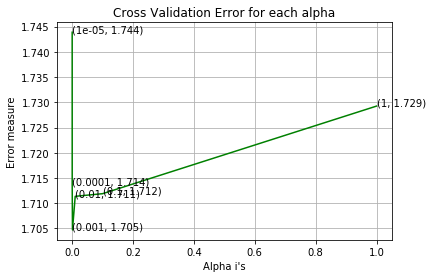

For values of best alpha =  0.001 The train log loss is: 1.6893629024002608
For values of best alpha =  0.001 The cross validation log loss is: 1.7047165770865134
For values of best alpha =  0.001 The test log loss is: 1.6996930807377832


In [33]:
#Testing the feature by creating a model with max_frequent_word_class values only as training data
cv_log_error_array=[]
alpha = [10 ** x for x in range(-5, 1)]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(one_hot_train, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_train,train_y)
    predict_y = sig_clf.predict_proba(one_hot_cv)
    
    cv_log_error_array.append(log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(one_hot_train, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_train, train_y)

predict_y = sig_clf.predict_proba(one_hot_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(one_hot_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(one_hot_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

<h6>Final Observation: </h6>
    
<p>
The model constructed with max_frequent_word_class only as the train data works pretty well yielding a log
loss of 1.69.Also a point to note is that there is no overfit in the model.train,test and cv log losses are almost 
the same
</p>

<h2>NEWLY ENGINEERED FEATURE 2: IS-FUSION(BOOLEAN OR 2-CLASS CATEGORICAL FEATURE)</h2>

In [ ]:
#####################################################################################
#idea courtesy:https://www.kaggle.com/eavdeeva/cancer-all-gene-variation-values-are-unique
Variation feature of the data has a special type of feature called fusion which is because of the fusion of two
gene.Hence we can make use of this special type of variation as a feature to identify the classes

In [34]:
train_df['Variation'].head(20)

0                   T1720A
1        CD74-NTRK1_Fusion
2     Truncating_Mutations
3                    T798I
4                    F367S
5                    Q209L
6                   R2888C
7                   R1515H
8                    L145R
9                  Fusions
10            A750_E758del
11                   Y253F
12                   F354L
13            G776delinsVC
14                    L64P
15                   L348F
16                   D257N
17                   I111A
18                   E219K
19                   R715G
Name: Variation, dtype: object

In [35]:
def is_fusion_feature(variation):
    if "fusion" in variation.lower():
        return 1
    else:
        return 0

In [36]:
#Creating the new feature values for train,test and cross validation data
is_fusion_cv = []
is_fusion_train = []
is_fusion_test = []
for index, each in cv_df.iterrows():
    is_fusion_cv.append(is_fusion_feature(each['Variation']))
for index, each in train_df.iterrows():
    is_fusion_train.append(is_fusion_feature(each['Variation']))
for index, each in test_df.iterrows():
    is_fusion_test.append(is_fusion_feature(each['Variation']))

In [37]:
#Appending the new feature created to train, test and cv data
is_fusion_cv = pd.DataFrame(is_fusion_cv, columns=['is_fusion'])
is_fusion_cv.index = cv_df.index
is_fusion_cv['ID'] = cv_df['ID']
cv_df = cv_df.merge(is_fusion_cv, on='ID',how='left')


is_fusion_train = pd.DataFrame(is_fusion_train, columns=['is_fusion'])
is_fusion_train.index = train_df.index
is_fusion_train['ID'] = train_df['ID']
train_df = train_df.merge(is_fusion_train, on='ID',how='left')


is_fusion_test = pd.DataFrame(is_fusion_test, columns=['is_fusion'])
is_fusion_test.index = test_df.index
is_fusion_test['ID'] = test_df['ID']
test_df = test_df.merge(is_fusion_test, on='ID',how='left')

In [38]:
train_df.head(5)

,ID,Gene,Variation,Class,TEXT,max_frequent_word_class,is_fusion
0,2630,BRCA1,T1720A,5,abstract germline mutations inactivate tumor s...,6,0
1,3224,NTRK1,CD74-NTRK1_Fusion,7,identified novel gene fusions patients lung ca...,7,1
2,870,HLA-B,Truncating_Mutations,1,abstract characterization novel hla b null all...,1,0
3,750,ERBB2,T798I,8,purpose mutations associated resistance kinase...,8,0
4,1713,POLE,F367S,4,abstract genomic sequences encoding 3 exonucle...,2,0


<h3>EDA of the max_frequent_word_class feature </h3>

In [39]:
#To view the distribution of is_fusion feature in each of the class in train data
class1_is_fusion_distribution = train_df[train_df['Class']==1]['is_fusion'].value_counts().sortlevel()
class2_is_fusion_distribution = train_df[train_df['Class']==2]['is_fusion'].value_counts().sortlevel()
class3_is_fusion_distribution = train_df[train_df['Class']==3]['is_fusion'].value_counts().sortlevel()
class4_is_fusion_distribution = train_df[train_df['Class']==4]['is_fusion'].value_counts().sortlevel()
class5_is_fusion_distribution = train_df[train_df['Class']==5]['is_fusion'].value_counts().sortlevel()
class6_is_fusion_distribution = train_df[train_df['Class']==6]['is_fusion'].value_counts().sortlevel()
class7_is_fusion_distribution = train_df[train_df['Class']==7]['is_fusion'].value_counts().sortlevel()
class8_is_fusion_distribution = train_df[train_df['Class']==8]['is_fusion'].value_counts().sortlevel()
class9_is_fusion_distribution = train_df[train_df['Class']==9]['is_fusion'].value_counts().sortlevel()

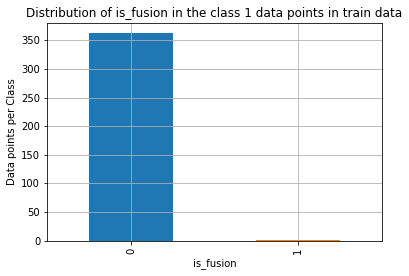

In [40]:
#Distribution of is_fusion in the class 1 data points in train data
my_colors ='rgbkymc'
class1_is_fusion_distribution.plot(kind='bar')
plt.xlabel('is_fusion')
plt.ylabel('Data points per Class')
plt.title('Distribution of is_fusion in the class 1 data points in train data')
plt.grid()
plt.show()

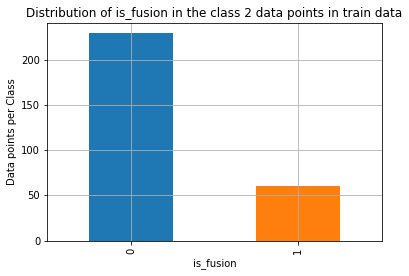

In [41]:
#Distribution of is_fusion in the class 2 data points in train data
my_colors ='rgbkymc'
class2_is_fusion_distribution.plot(kind='bar')
plt.xlabel('is_fusion')
plt.ylabel('Data points per Class')
plt.title('Distribution of is_fusion in the class 2 data points in train data')
plt.grid()
plt.show()

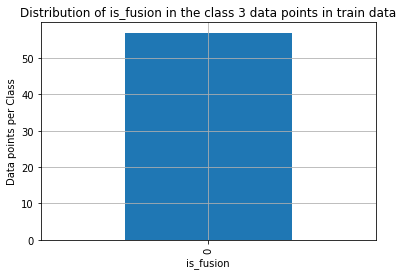

In [42]:
#Distribution of is_fusion in the class 3 data points in train data
my_colors ='rgbkymc'
class3_is_fusion_distribution.plot(kind='bar')
plt.xlabel('is_fusion')
plt.ylabel('Data points per Class')
plt.title('Distribution of is_fusion in the class 3 data points in train data')
plt.grid()
plt.show()

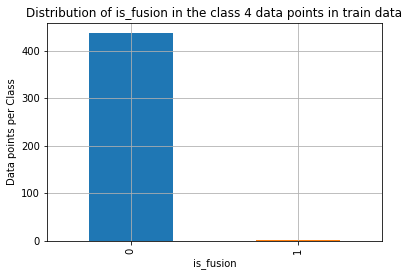

In [43]:
#Distribution of is_fusion in the class 4 data points in train data
my_colors ='rgbkymc'
class4_is_fusion_distribution.plot(kind='bar')
plt.xlabel('is_fusion')
plt.ylabel('Data points per Class')
plt.title('Distribution of is_fusion in the class 4 data points in train data')
plt.grid()
plt.show()

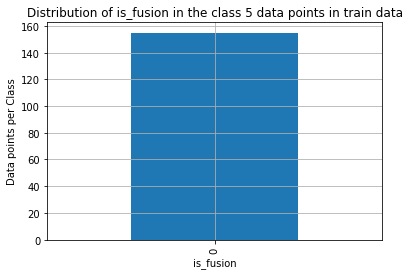

In [44]:
#Distribution of is_fusion in the class 5 data points in train data
my_colors ='rgbkymc'
class5_is_fusion_distribution.plot(kind='bar')
plt.xlabel('is_fusion')
plt.ylabel('Data points per Class')
plt.title('Distribution of is_fusion in the class 5 data points in train data')
plt.grid()
plt.show()

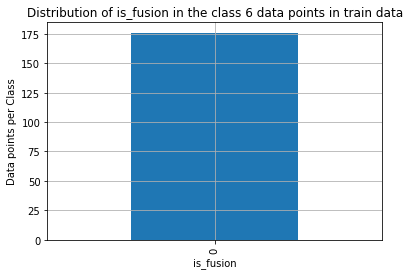

In [45]:
#Distribution of is_fusion in the class 6 data points in train data
my_colors ='rgbkymc'
class6_is_fusion_distribution.plot(kind='bar')
plt.xlabel('is_fusion')
plt.ylabel('Data points per Class')
plt.title('Distribution of is_fusion in the class 6 data points in train data')
plt.grid()
plt.show()

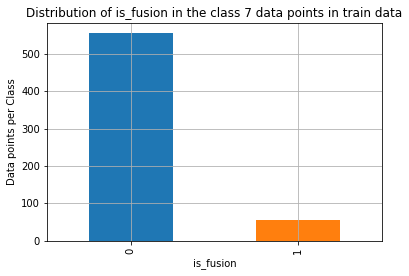

In [46]:
#Distribution of is_fusion in the class 7 data points in train data
my_colors ='rgbkymc'
class7_is_fusion_distribution.plot(kind='bar')
plt.xlabel('is_fusion')
plt.ylabel('Data points per Class')
plt.title('Distribution of is_fusion in the class 7 data points in train data')
plt.grid()
plt.show()

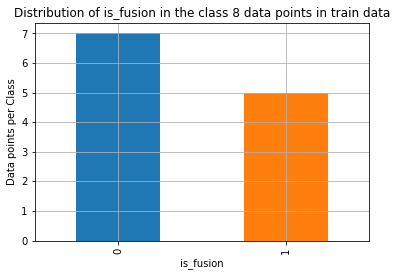

In [47]:
#Distribution of is_fusion in the class 8 data points in train data
my_colors ='rgbkymc'
class8_is_fusion_distribution.plot(kind='bar')
plt.xlabel('is_fusion')
plt.ylabel('Data points per Class')
plt.title('Distribution of is_fusion in the class 8 data points in train data')
plt.grid()
plt.show()

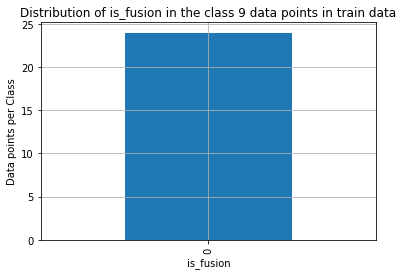

In [48]:
#Distribution of is_fusion in the class 9 data points in train data
my_colors ='rgbkymc'
class9_is_fusion_distribution.plot(kind='bar')
plt.xlabel('is_fusion')
plt.ylabel('Data points per Class')
plt.title('Distribution of is_fusion in the class 9 data points in train data')
plt.grid()
plt.show()

<h6>Final Observation:</h6>
<p>
1) on observing the fusion variation in each of the class, we can observe that most classes like 1,3,4,5,6,9
have no fusion variation.class 1 have very small fusion variation while class 2 and 7 have some descent number of 
fusion variation.Of all classes, class 8 has more number of fusion variation.Let us build a model actually
to determine how good this can predict our class labels
</p>

<h3>How good is_fusion is in predicting yis </h3>

In [49]:
#Since it is a categorical features,one hot encoding of the feature is done
one_hot_train_fusion = pd.get_dummies(train_df['is_fusion'])
one_hot_cv_fusion = pd.get_dummies(cv_df['is_fusion'])
one_hot_test_fusion = pd.get_dummies(test_df['is_fusion'])

For values of alpha =  1e-05 The log loss is: 1.8074486673637478
For values of alpha =  0.0001 The log loss is: 1.8074486729130934
For values of alpha =  0.001 The log loss is: 1.8074486656185158
For values of alpha =  0.01 The log loss is: 1.807448664508148
For values of alpha =  0.1 The log loss is: 1.8074486902997133
For values of alpha =  1 The log loss is: 1.8074486630285105


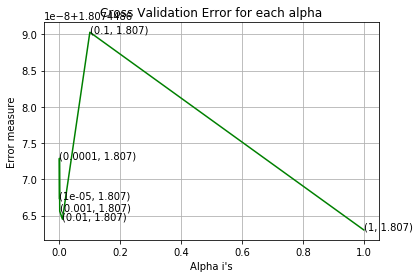

For values of best alpha =  1 The train log loss is: 1.78079805718756
For values of best alpha =  1 The cross validation log loss is: 1.8074486630285105
For values of best alpha =  1 The test log loss is: 1.7803977588326685


In [50]:
#Testing the feature by creating a model with max_frequent_word_class values only as training data
cv_log_error_array=[]
alpha = [10 ** x for x in range(-5, 1)]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(one_hot_train_fusion, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(one_hot_train_fusion,train_y)
    predict_y = sig_clf.predict_proba(one_hot_cv_fusion)
    
    cv_log_error_array.append(log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(one_hot_train_fusion, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(one_hot_train_fusion, train_y)

predict_y = sig_clf.predict_proba(one_hot_train_fusion)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(one_hot_cv_fusion)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(one_hot_test_fusion)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

<h6>Final Observation:</h6>
<p>
on building a model with just fusion variation as train data, we get a good log loss of 1.78.Let us give a try and 
incorporate these feature in train data
</p>

<h3>construction and evaluation of the model with newly constructed feature</h3>

In [51]:
train_df = train_df.drop('max_frequent_word_class', axis=1)
train_df = train_df.join(one_hot_train)

In [52]:
cv_df = cv_df.drop('max_frequent_word_class', axis=1)
cv_df = cv_df.join(one_hot_train)

In [53]:
test_df = test_df.drop('max_frequent_word_class', axis=1)
test_df = test_df.join(one_hot_train)

In [54]:
train_df = train_df.drop('is_fusion', axis=1)
train_df = train_df.join(one_hot_train_fusion)

cv_df = cv_df.drop('is_fusion', axis=1)
cv_df = cv_df.join(one_hot_train_fusion)

test_df = test_df.drop('is_fusion', axis=1)
test_df = test_df.join(one_hot_train_fusion)

In [55]:
train_x_tfidfvector.shape

(2124, 56413)

In [56]:
train_x_tfidfvector = hstack((train_x_tfidfvector, np.array(train_df['c1'])[:, None], 
                             np.array(train_df['c2'])[:, None], np.array(train_df['c3'])[:, None],
                             np.array(train_df['c4'])[:, None], np.array(train_df['c5'])[:, None],
                             np.array(train_df['c6'])[:, None], np.array(train_df['c7'])[:, None],
                             np.array(train_df['c8'])[:, None], np.array(train_df['c9'])[:, None] ))                             
train_x_tfidfvector = hstack((train_x_tfidfvector, np.array(train_df[0])[:, None], 
                             np.array(train_df[1])[:, None]))      

In [57]:
train_x_tfidfvector.shape

(2124, 56424)

In [58]:
cv_x_tfidfvector.shape

(532, 56413)

In [59]:
cv_x_tfidfvector = hstack((cv_x_tfidfvector, np.array(cv_df['c1'])[:, None], 
                             np.array(cv_df['c2'])[:, None], np.array(cv_df['c3'])[:, None],
                             np.array(cv_df['c4'])[:, None], np.array(cv_df['c5'])[:, None],
                             np.array(cv_df['c6'])[:, None], np.array(cv_df['c7'])[:, None],
                             np.array(cv_df['c8'])[:, None], np.array(cv_df['c9'])[:, None] ))
cv_x_tfidfvector = hstack((cv_x_tfidfvector, np.array(cv_df[0])[:, None], 
                             np.array(cv_df[1])[:, None]))         

In [60]:
cv_x_tfidfvector.shape

(532, 56424)

In [61]:
test_x_tfidfvector = hstack((test_x_tfidfvector, np.array(test_df['c1'])[:, None], 
                             np.array(test_df['c2'])[:, None], np.array(test_df['c3'])[:, None],
                             np.array(test_df['c4'])[:, None], np.array(test_df['c5'])[:, None],
                             np.array(test_df['c6'])[:, None], np.array(test_df['c7'])[:, None],
                             np.array(test_df['c8'])[:, None], np.array(test_df['c9'])[:, None] ))
test_x_tfidfvector = hstack((test_x_tfidfvector, np.array(test_df[0])[:, None], 
                             np.array(test_df[1])[:, None]))         

In [62]:
test_x_tfidfvector.shape

(665, 56424)

In [63]:
train_x_vec = train_x_tfidfvector
test_x_vec = test_x_tfidfvector
cv_x_vec = cv_x_tfidfvector

In [64]:
print(train_x_vec.shape)
print(cv_x_vec.shape)
print(test_x_vec.shape)

(2124, 56424)
(532, 56424)
(665, 56424)


for alpha = 1e-06
Log Loss : 0.9073867975859934
for alpha = 1e-05
Log Loss : 0.9044750627737089
for alpha = 0.0001
Log Loss : 0.8953208944103994
for alpha = 0.001
Log Loss : 0.7121827349989553
for alpha = 0.01
Log Loss : 0.7510656599165514
for alpha = 0.1
Log Loss : 1.0740817190159928
for alpha = 1
Log Loss : 1.5079743620293764
for alpha = 10
Log Loss : 1.6349686920557633
for alpha = 100
Log Loss : 1.648846965963995


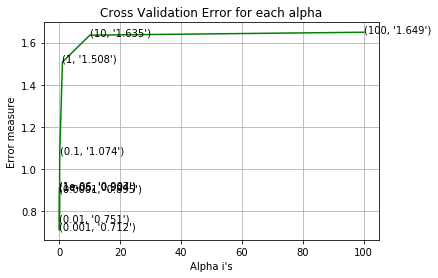

For values of best alpha =  0.001 The train log loss is: 0.5757936948081439
For values of best alpha =  0.001 The cross validation log loss is: 0.7121827349989553
For values of best alpha =  0.001 The test log loss is: 0.7092297776807072


In [65]:
#Rerunning LR model on the feature engineered data
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier( alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_vec, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

<h6>Final Observation:</h6>
<p>
The new feaure engineered data gives a very good log loss of 0.70.There is still little bit overfit in the model
as there is a small difference in train and test log loss,though test and cv log losses are the same
</p>

<h2> Failed Feature Engineering </h2>

<p>
All the features which are mentioned above are already used in the train data but instead of decreasing the log loss
it increased the log loss because of the inherent problem in it which will be explained in each of the section
<p>

<h3>Text Length </h3>

<p>This is a simple feature which is the total length of the text in the data point</p>

In [66]:
def get_text_length(text):
    return len(text)

In [67]:
#Creating the new feature values for train,test and cross validation data
text_length_cv = []
text_length_train = []
text_length_test = []
for index, each in cv_df.iterrows():
    text_length_cv.append(get_text_length(each['TEXT']))
for index, each in train_df.iterrows():
    text_length_train.append(get_text_length(each['TEXT']))
for index, each in test_df.iterrows():
    text_length_test.append(get_text_length(each['TEXT']))

In [68]:
text_length_train_frame = pd.DataFrame(text_length_train, columns=['text_length'])
text_length_train_frame.index = train_df.index
text_length_train_frame['ID'] = train_df['ID']
train_df = train_df.merge(text_length_train_frame, on='ID',how='left')
train_df.head(5)

,ID,Gene,Variation,Class,TEXT,c1,c2,c3,c4,c5,c6,c7,c8,c9,0,1,text_length
0,2630,BRCA1,T1720A,5,abstract germline mutations inactivate tumor s...,0,0,0,0,0,1,0,0,0,1,0,125688
1,3224,NTRK1,CD74-NTRK1_Fusion,7,identified novel gene fusions patients lung ca...,0,0,0,0,0,0,1,0,0,0,1,6644
2,870,HLA-B,Truncating_Mutations,1,abstract characterization novel hla b null all...,1,0,0,0,0,0,0,0,0,1,0,23134
3,750,ERBB2,T798I,8,purpose mutations associated resistance kinase...,0,0,0,0,0,0,0,1,0,1,0,69236
4,1713,POLE,F367S,4,abstract genomic sequences encoding 3 exonucle...,0,1,0,0,0,0,0,0,0,1,0,38950


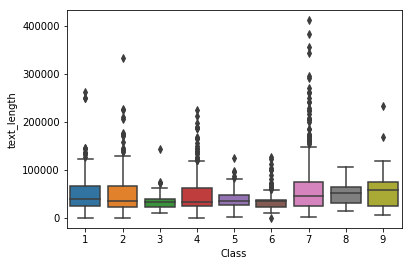

In [69]:
sns.boxplot(x='Class',y='text_length', data=train_df)
plt.show()

<h6>Final Observation:</h6>
<p> 
As we can see from the above feature, the quantile values of text length feature for all the 9 classes are almost
same and hence they overlap.Since there is not significant difference in the text length of all the classes,
this is causing a confusion in model prediction reducing the probability of prediction thereby increasing the log loss
</p>

<h3>No of unique words </h3>

<p>Another simple feature which is the number of unique words in the text feature of the data</p>

In [70]:
def get_number_of_unique_words(text):
    number_of_words = text.split()
    return len(set(number_of_words))

In [71]:
#Creating the new feature values for train,test and cross validation data
num_of_words_cv = []
num_of_words_train = []
num_of_words_test = []
for index, each in cv_df.iterrows():
    num_of_words_cv.append(get_number_of_unique_words(each['TEXT']))
for index, each in train_df.iterrows():
    num_of_words_train.append(get_number_of_unique_words(each['TEXT']))
for index, each in test_df.iterrows():
    num_of_words_test.append(get_number_of_unique_words(each['TEXT']))

In [72]:
num_of_words_train = pd.DataFrame(num_of_words_train, columns=['num_of_words'])
num_of_words_train.index = train_df.index
num_of_words_train['ID'] = train_df['ID']
train_df = train_df.merge(num_of_words_train, on='ID',how='left')
train_df.head(5)

,ID,Gene,Variation,Class,TEXT,c1,c2,c3,c4,c5,c6,c7,c8,c9,0,1,text_length,num_of_words
0,2630,BRCA1,T1720A,5,abstract germline mutations inactivate tumor s...,0,0,0,0,0,1,0,0,0,1,0,125688,3206
1,3224,NTRK1,CD74-NTRK1_Fusion,7,identified novel gene fusions patients lung ca...,0,0,0,0,0,0,1,0,0,0,1,6644,400
2,870,HLA-B,Truncating_Mutations,1,abstract characterization novel hla b null all...,1,0,0,0,0,0,0,0,0,1,0,23134,974
3,750,ERBB2,T798I,8,purpose mutations associated resistance kinase...,0,0,0,0,0,0,0,1,0,1,0,69236,1955
4,1713,POLE,F367S,4,abstract genomic sequences encoding 3 exonucle...,0,1,0,0,0,0,0,0,0,1,0,38950,1429


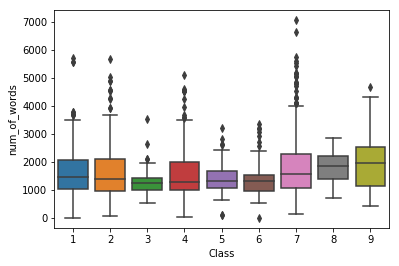

In [73]:
sns.boxplot(x='Class',y='num_of_words', data=train_df)
plt.show()

<p>
Final Observation:
    This also runs out of same problem as that of the text length features.There is no significant information 
in classification as all quantile values overlap.Hence it screws up the log loss
</p>

<h3>Average TF_IDF</h3>

<p>Yet another feature which is the average of TF-IDF values of all the unique words in the text feature of the data</p>

In [74]:
def get_average_tf_idf(text):
    avg_tfidf = 0
    text = text.split()
    text = set(text)
    words = 0
    for each in text:
        if each in words_tfidf_dict:
            avg_tfidf = avg_tfidf + words_tfidf_dict[each]
            words = words + 1 
    if words == 0:
        return 0
    return avg_tfidf/words

In [75]:
#Creating the new feature values for train,test and cross validation data
average_tf_idf_cv = []
average_tf_idf_train = []
average_tf_idf_test = []
for index, each in cv_df.iterrows():
    average_tf_idf_cv.append(get_average_tf_idf(each['TEXT']))
for index, each in train_df.iterrows():
    average_tf_idf_train.append(get_average_tf_idf(each['TEXT']))
for index, each in test_df.iterrows():
    average_tf_idf_test.append(get_average_tf_idf(each['TEXT']))

In [76]:
average_tf_idf_train_frame = pd.DataFrame(average_tf_idf_train, columns=['avg_tfidf'])
average_tf_idf_train_frame.index = train_df.index
average_tf_idf_train_frame['ID'] = train_df['ID']
train_df = train_df.merge(average_tf_idf_train_frame, on='ID',how='left')
train_df.head(5)

,ID,Gene,Variation,Class,TEXT,c1,c2,c3,c4,c5,c6,c7,c8,c9,0,1,text_length,num_of_words,avg_tfidf
0,2630,BRCA1,T1720A,5,abstract germline mutations inactivate tumor s...,0,0,0,0,0,1,0,0,0,1,0,125688,3206,0.040569
1,3224,NTRK1,CD74-NTRK1_Fusion,7,identified novel gene fusions patients lung ca...,0,0,0,0,0,0,1,0,0,0,1,6644,400,0.020348
2,870,HLA-B,Truncating_Mutations,1,abstract characterization novel hla b null all...,1,0,0,0,0,0,0,0,0,1,0,23134,974,0.023695
3,750,ERBB2,T798I,8,purpose mutations associated resistance kinase...,0,0,0,0,0,0,0,1,0,1,0,69236,1955,0.022852
4,1713,POLE,F367S,4,abstract genomic sequences encoding 3 exonucle...,0,1,0,0,0,0,0,0,0,1,0,38950,1429,0.023323


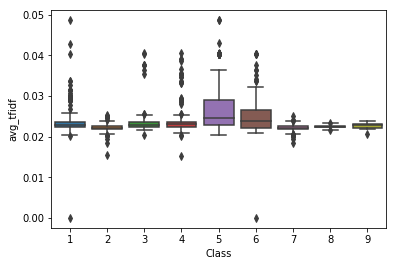

In [77]:
sns.boxplot(x='Class',y='avg_tfidf', data=train_df)
plt.show()

<h6>Final Observation</h6>
<p>
Same as that of the other features,though class 5 and 6 have a little larger 75th percentile values,others just
almost overlaps.This causes a reduction in probabalility and increases log loss
</p>

<h3>Gene-Variation Mix</h3>

<p>A feature of domain relevance.Since variation is the change that happens in the gene.Clubbing gene and
corresponding gene together may give some information
</p>

In [78]:
#Idea courtesy:https://www.kaggle.com/eavdeeva/cancer-all-gene-variation-values-are-unique
def gene_and_variation(gene, variation):
    return gene + " " + variation

In [79]:
#Creating the new feature values for train,test and cross validation data
gene_variation_cv = []
gene_variation_train = []
gene_variation_test = []
for index, each in cv_df.iterrows():
    gene_variation_cv.append(gene_and_variation(each['Gene'], each['Variation']))
for index, each in train_df.iterrows():
    gene_variation_train.append(gene_and_variation(each['Gene'], each['Variation']))
for index, each in test_df.iterrows():
    gene_variation_test.append(gene_and_variation(each['Gene'], each['Variation']))

In [80]:
#Appending the new feature created to train, test and cv data
gene_variation_cv = pd.DataFrame(gene_variation_cv, columns=['gene_variation'])
gene_variation_cv.index = cv_df.index
gene_variation_cv['ID'] = cv_df['ID']
cv_df = cv_df.merge(gene_variation_cv, on='ID',how='left')


gene_variation_train = pd.DataFrame(gene_variation_train, columns=['gene_variation'])
gene_variation_train.index = train_df.index
gene_variation_train['ID'] = train_df['ID']
train_df = train_df.merge(gene_variation_train, on='ID',how='left')


gene_variation_test = pd.DataFrame(gene_variation_test, columns=['gene_variation'])
gene_variation_test.index = test_df.index
gene_variation_test['ID'] = test_df['ID']
test_df = test_df.merge(gene_variation_test, on='ID',how='left')

In [81]:
train_df.head(3)

,ID,Gene,Variation,Class,TEXT,c1,c2,c3,c4,c5,c6,c7,c8,c9,0,1,text_length,num_of_words,avg_tfidf,gene_variation
0,2630,BRCA1,T1720A,5,abstract germline mutations inactivate tumor s...,0,0,0,0,0,1,0,0,0,1,0,125688,3206,0.040569,BRCA1 T1720A
1,3224,NTRK1,CD74-NTRK1_Fusion,7,identified novel gene fusions patients lung ca...,0,0,0,0,0,0,1,0,0,0,1,6644,400,0.020348,NTRK1 CD74-NTRK1_Fusion
2,870,HLA-B,Truncating_Mutations,1,abstract characterization novel hla b null all...,1,0,0,0,0,0,0,0,0,1,0,23134,974,0.023695,HLA-B Truncating_Mutations


In [83]:
unique_gene_variation = train_df['gene_variation'].value_counts()
print('Number of Unique Gene variation :', unique_gene_variation.shape[0])
# the top 10 variation that occured most
print(unique_gene_variation.head(10))

Number of Unique Gene variation : 2124
PIK3CA P449_L455del        1
BRCA1 L1267S               1
PMS2 R20Q                  1
BRCA1 M1628V               1
DICER1 Deletion            1
TERT Promoter_Mutations    1
SPOP R121Q                 1
BRAF V600R                 1
ERBB2 Amplification        1
FGFR3 G697C                1
Name: gene_variation, dtype: int64


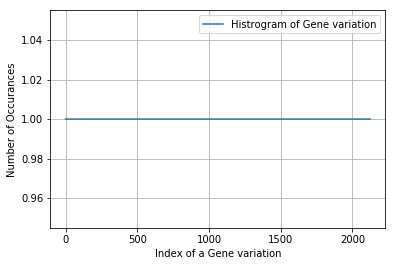

In [87]:
h = unique_gene_variation.values;
plt.plot(h, label="Histrogram of Gene variation")
plt.xlabel('Index of a Gene variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

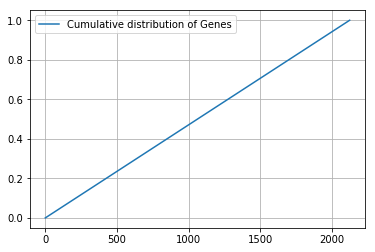

In [85]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [86]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_gene_variation.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['gene_variation'].isin(list(set(train_df['gene_variation'])))].shape[0]
cv_coverage=cv_df[cv_df['gene_variation'].isin(list(set(train_df['gene_variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  2124  genes in train dataset?
Ans
1. In test data 422 out of 665 : 63.45864661654136
2. In cross validation data 338 out of  532 : 63.53383458646616


<h6>Final Observation</h6>
<p>
As we can see that all the train data points have a unique gene-variation combo as there are 2124 unique gene
variation.Each of the gene-variation occurs only once.Also we can observe that the feature is unstable
as only 63% of the gene-variations in cv and test data are there in train data.These things imply this feature
is not much useful.And this fact is proved when I build model using this feature which caused the log loss
to shoot up
</p>

<h1 align="center">Final Observation</h1>

<h3>Observations for TF-IDF Vector based models </h3> 

In [3]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Hyper Parameter", "Train log loss", "CV logloss", "Test logloss","% of mis-classified pts"]
x.add_row(["Naive Bayes", "alpha =  0.001", 0.9177751,1.2289117,1.20801,0.41 ] )
x.add_row(["KNN","K=5",0.9691078,1.241641, 1.220932,0.43 ] )
x.add_row(["Logistic Regression - \n With Class balancing","alpha =  0.01", 0.655689, 1.0899374, 1.0984357, 0.34 ] )
x.add_row(["Logistic Regression -  \n Without Class balancing","alpha =  0.001",0.575303,1.152205, 1.057554, 0.37  ] )
x.add_row(["Linear SVM","alpha =  0.01", 0.697548, 1.146736, 1.093993, 0.37 ] )
x.add_row(["Random Forest Classifier"," best estimator =  2000",0.63665, 1.148975 , 1.13466, 0.38  ] )
x.add_row(["Stack the models","", 0.6425317, 1.142678, 1.13603,  0.38 ] )
x.add_row(["Maximum Voting classifier","",0.860248, 1.1496490 , 1.1476675, 0.38  ] )
print(x)

+---------------------------+-------------------------+----------------+------------+--------------+-------------------------+
|           Model           |     Hyper Parameter     | Train log loss | CV logloss | Test logloss | % of mis-classified pts |
+---------------------------+-------------------------+----------------+------------+--------------+-------------------------+
|        Naive Bayes        |      alpha =  0.001     |   0.9177751    | 1.2289117  |   1.20801    |           0.41          |
|            KNN            |           K=5           |   0.9691078    |  1.241641  |   1.220932   |           0.43          |
|   Logistic Regression -   |      alpha =  0.01      |    0.655689    | 1.0899374  |  1.0984357   |           0.34          |
|    With Class balancing   |                         |                |            |              |                         |
|  Logistic Regression -    |      alpha =  0.001     |    0.575303    |  1.152205  |   1.057554   |           

<h3>Observations for top 1000 words based TF-IDF Vector based models</h3>

In [4]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Hyper Parameter", "Train log loss", "CV logloss", "Test logloss","% of mis-classified pts"]
x.add_row(["Naive Bayes", "alpha =  0.001", 0.524000,1.152780,1.23624,0.36 ] )
x.add_row(["KNN","K=5",0.86886,1.061335, 1.07617,0.37 ] )
x.add_row(["Logistic Regression - \n With Class balancing","alpha =  0.01", 0.65568, 1.089937, 1.09843,0.34 ] )
x.add_row(["Logistic Regression -  \n Without Class balancing","alpha =  0.001",0.57530,1.15220, 1.05755, 0.37  ] )
x.add_row(["Linear SVM","alpha =  0.001", 0.61501,  1.04596, 1.08198, 0.35 ] )
x.add_row(["Random Forest Classifier"," best estimator =  2000",0.847296, 1.173494 , 1.182599,0.39 ] )
x.add_row(["Stack the models","", 0.53767, 1.114471, 1.202442, 0.38 ] )
x.add_row(["Maximum Voting classifier","",0.832065, 1.158737, 1.2039784,0.37  ] )
print(x)

+---------------------------+-------------------------+----------------+------------+--------------+-------------------------+
|           Model           |     Hyper Parameter     | Train log loss | CV logloss | Test logloss | % of mis-classified pts |
+---------------------------+-------------------------+----------------+------------+--------------+-------------------------+
|        Naive Bayes        |      alpha =  0.001     |     0.524      |  1.15278   |   1.23624    |           0.36          |
|            KNN            |           K=5           |    0.86886     |  1.061335  |   1.07617    |           0.37          |
|   Logistic Regression -   |      alpha =  0.01      |    0.65568     |  1.089937  |   1.09843    |           0.34          |
|    With Class balancing   |                         |                |            |              |                         |
|  Logistic Regression -    |      alpha =  0.001     |     0.5753     |   1.1522   |   1.05755    |           

<h3>Observation for count vectorizer with ngrams</h3>

In [6]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Hyper Parameter", "Train log loss", "CV logloss", "Test logloss", "% of mis-classified pts"]
x.add_row(["Logistic Regression - \n With Class balancing","alpha =  0.1", 0.8386798, 1.19655, 1.178669, 0.41 ] )
x.add_row(["Logistic Regression -  \n Without Class balancing","alpha =  0.1",0.82916,1.21264,  1.1895, 0.39 ] )
print(x)

+--------------------------+-----------------+----------------+------------+--------------+-------------------------+
|          Model           | Hyper Parameter | Train log loss | CV logloss | Test logloss | % of mis-classified pts |
+--------------------------+-----------------+----------------+------------+--------------+-------------------------+
|  Logistic Regression -   |   alpha =  0.1  |   0.8386798    |  1.19655   |   1.178669   |           0.41          |
|   With Class balancing   |                 |                |            |              |                         |
| Logistic Regression -    |   alpha =  0.1  |    0.82916     |  1.21264   |    1.1895    |           0.39          |
|  Without Class balancing |                 |                |            |              |                         |
+--------------------------+-----------------+----------------+------------+--------------+-------------------------+


<h6>Final Observation:</h6>
    
<p>
1)On creating based on the tf-idf vectorized data, the model which is best based on the log loss is LR model without
class balancing with log loss of 1.09.But on comparing with LR model with class balancing which has a log loss of
1.09 it has a higher mis-classified points of 37% while the class balanced LR model performs good with reduced %
misclassified points of 34%.Even linear svm with similar log loss of 1.09 has somewhat high misclassified points.
</p>
<p>
2)However, since the probability of prediction is more important the model concluded as the winner is LR model
without class balancing.But a key thing to be noted is that the model overfits a lot as there is a huge variation
in the test,train and cv log losses
</p>
<p>
3)Also the count vectors with n-grams doesnt improve the model much as we have only a 1.17 and 1.18 log loss.
But there is a significant improvement in the overfit as the gap between train,test and cv reduced a lot
</p>
<p>
4)The feature engineering actually improved the model a lot as we have a very good log loss of 0.70 and at the 
same time the overfit in the model has also curbed to an extent after the feature engineering
</p>